# **Lab 6: Convolutional Network Architectures - Brain Tumor MRI Images**

- Reece Iriye: 48255107
- Eileen Garcia: 48241821
- Trevor Dohm: 48376059

## **0: Imports**

In [12]:
# Import Statements

# MacOS Environment
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Data Manipulation
import numpy as np
import pandas as pd
import glob

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedShuffleSplit

# Image Manipulation
from PIL import Image, ImageEnhance
import cv2

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Reshape
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomContrast, RandomBrightness, average
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Accuracy, Precision, Recall

# Warnings
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Check Version, GPU Devices
print('Tensorflow Version:', tf.__version__)
tf.config.list_physical_devices('GPU')

Tensorflow Version: 2.14.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [4]:
# Set Specific (Unused) GPU
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')

## **1: Business & Data Understanding**

### **1.1: Dataset Overview**

The "Brain Tumor MRI Dataset" on <a href="https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset">Kaggle</a> provides a comprehensive collection of human brain MRI images aimed at supporting the accurate detection and classification of brain tumors. Consisting of 7,023 images from three distinct datasets - figshare, SARTAJ, and Br35H - this dataset separates MRI scans of brains into four categories: `glioma`, `meningioma`, `no tumor`, and `pituitary`. The dataset has seen several changes according to the description on Kaggle, with some `glioma` images from the SARTAJ dataset being replaced due to inaccuracies, highlighting ongoing modifications being made to the dataset for improved reliability and data quality. With images from the Br35H dataset constituting the `no tumor` class, users should be mindful that the images in this dataset come in varied sizes, meaning that pre-processing and re-sizing must be employed for us to achieve consistent analysis and improved model accuracy.

### **1.2: Purpose of Data Collection**

Brain tumors as a whole pose severe risks given the confined space of the skull, whether or not they are <a href="https://www.cedars-sinai.org/blog/diagnosed-with-benign-tumor.html">malignant or benign</a>. Growth of these tumors can potentially lead to brain damage and life-threatening situations. Timely detection and precise classification of these tumors are absolutely essential in guiding pre-emptive medical diagnosis before tumors signifcantly effect and harm a patient. With MRI's being a predominant imaging technique in this realm, there is a pressing need for advanced diagnostic models that can detect, classify by type, and pinpoint tumor locations effectively. This dataset, assembled from various sources and continuously refined, aims to provide a rich resource for researchers and data scientists to develop advanced machine learning models to aid in these critical diagnostic tasks.

This MRI dataset from Kaggle has been created with the specific intention to facilitate the development of models capable of detecting the presence of a brain tumor from MRI scans and classifying them by type. Medical practitioners and technicians can then use them as an advisory tool to make more precise diagnoses, leading to more targeted treatment options. Accurate labels are extremely important. It's crucial to acknowledge potential inaccuracies, such as those noted in the SARTAJ dataset, ensuring that machine learning models are trained on the most reliable data available.

### **1.3: Data Preprocessing Steps**

#### **1.3.1: Image Dimensions Standardization**

The Kaggle brain MRI dataset is structured in distinct training and testing folders. We are going to merge all of these together into one dataset then perform our own data splitting in section **2**.

All MRI images are likely varying in size, with some images being much larger than others and some images potentially being stretched in ways that could not be interpreted in a standard way by a Convolutional Neural Network or a transformer. We will standardize image size by stretching and/or squeezing images to fit into a $256 \times 256$ pixel dimension. This is a crucial preprocessing step. Neural networks, especially convolutional ones, require a consistent input size. Resizing all images to a uniform shape ensures that the network receives inputs in a consistent format, allowing us to batch process the data. Furthermore, downsizing larger images can also speed up the training process, as smaller images generally require less computational resources. On the other hand, recognizable features can be rendered from larger MRI screens with high dimensions could maybe lost from compression, but we are preferring interpretability in this scenario.

Because the images are MRI scans, we will read in the data and ensure that the images are grayscaled. MRI scans represent variations in tissue properties, not colors as in everyday images. Hence, we read in the data ensuring the images are in grayscale. Grayscaling, in this context, isn't about removing color; instead, it's about representing the MRI scans in a format that aligns with their natural presentation. By using grayscale, we utilize a single channel of floating point values, as opposed to the three channels (RGB) found in colored images. This not only aligns with the nature of MRI scans but also reduces the memory requirement to represent these images by one-third, making processing more efficient.

We will normalize the floating point representation of each grayscaled pixel value by dividing pixel values by 255. This scales all pixel values between 0 and 1. Normalization is an important step in image processing for neural networks, because networks tend to converge faster with normalized inputs. By keeping pixel values within a small range, it ensures that no particular set of weights gets updated disproportionately during the backpropagation process when fine-tuning or training a neural network.

In [5]:
# Load Train / Test Data
train_data_mri: str = 'Dataset/Training/'
test_data_mri: str = 'Dataset/Testing/'
IMG_SIZE: int = 256
NUM_CLASSES: int = 4

# Label Encoding
labels: List[str] = ['glioma', 'meningioma', 'notumor', 'pituitary']
label_indexes: Dict[str, int] = {
    label: i 
    for i, label in enumerate(labels)
}

# Empty Lists For Data
train_paths: List[np.ndarray] = []  # List of numpy arrays
train_labels: List[int] = []  # List of integers (encoded labels)
test_paths: List[np.ndarray] = []
test_labels: List[int] = []

# Load Training Data
for label in labels:
    for img_file in glob.glob(train_data_mri + f'/{label}/*.jpg'):
        img: np.ndarray = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img.astype(np.float32) / 255.0  # Normalize pixel values
        train_paths.append(img)
        train_labels.append(label_indexes[label])

# Load Testing Data
for label in labels:
    for img_file in glob.glob(test_data_mri + f'/{label}/*.jpg'):
        img: np.ndarray = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img.astype(np.float32) / 255.0  # Normalize pixel values
        test_paths.append(img)
        test_labels.append(label_indexes[label])  

# Converting Lists To Numpy Arrays
train_paths = np.array(train_paths)
train_labels: np.ndarray = np.array(train_labels)
test_paths: np.ndarray = np.array(test_paths)
test_labels: np.ndarray = np.array(test_labels)

Ideally, having more images to train on would be preferrable, but 5,712 MRI scans spanning across multiple data sources is strong nonetheless. Diving deeper, let's check the total appearances for each class in the training data. 

In [10]:
# Find Indices For Each Label

train_indices_0: List[int] = np.where(np.array(train_labels) == 0)[0]
train_indices_1: List[int] = np.where(np.array(train_labels) == 1)[0]
train_indices_2: List[int] = np.where(np.array(train_labels) == 2)[0]
train_indices_3: List[int] = np.where(np.array(train_labels) == 3)[0]

test_indices_0: List[int] = np.where(np.array(test_labels) == 0)[0]
test_indices_1: List[int] = np.where(np.array(test_labels) == 1)[0]
test_indices_2: List[int] = np.where(np.array(test_labels) == 2)[0]
test_indices_3: List[int] = np.where(np.array(test_labels) == 3)[0]

# Total Class Distributions

print(f"Glioma Training Data MRI Scans: {len(train_indices_0)}.")
print(f"Meningioma Training Data MRI Scans: {len(train_indices_1)}.")
print(f"No Tumor Training Data MRI Scans: {len(train_indices_2)}.")
print(f"Pituitary Training Data MRI Scans: {len(train_indices_3)}.")
print("Total MRI Scans With Tumor: {}.".format(
    len(train_indices_0) + len(train_indices_1) + len(train_indices_3)
))

Glioma Training Data MRI Scans: 1321.
Meningioma Training Data MRI Scans: 1339.
No Tumor Training Data MRI Scans: 1595.
Pituitary Training Data MRI Scans: 1457.
Total MRI Scans With Tumor: 4117.


The MRI scans labeled as "no tumor" form a significant portion when compared to individual tumor classes. However, overall, the classes are relatively well-balanced. If our goal is to classify the specific type of tumor, this even distribution is advantageous, as it minimizes the risk of the model being overly biased towards a particular class.

On the other hand, if the objective shifts to merely detecting the presence or absence of a tumor, there's a potential pitfall. Out of the 5,712 images, 4,117 showcase some form of tumor. In such a scenario, a binary classification model might be more inclined to predict the presence of a tumor, given that it represents the majority of the dataset. This could lead to the model being overly optimistic about tumor existence. This is actually not terrible problem to have, as a model that overly predicts the existence of a tumor is much stronger than a model that does the opposite. The reason why is because the implications for a false positive for predicting the existence of a tumor is much less costly then a false negative where the model misses a tumor.

### **1.4: Visualizing Content in the Dataset**

#### **1.4.1: Displaying Some Images**

In the plot below, we display some images from the training folder provided by Kaggle. The first 10 images with a label 0 represent a glioma tumor, the next 10 images with a label 1 represent a meningioma tumor, then the 10 after that with the label 2 represent a lack of existence of a tumor, and the last 10 images with the label 3 represent pituitary tumors. 

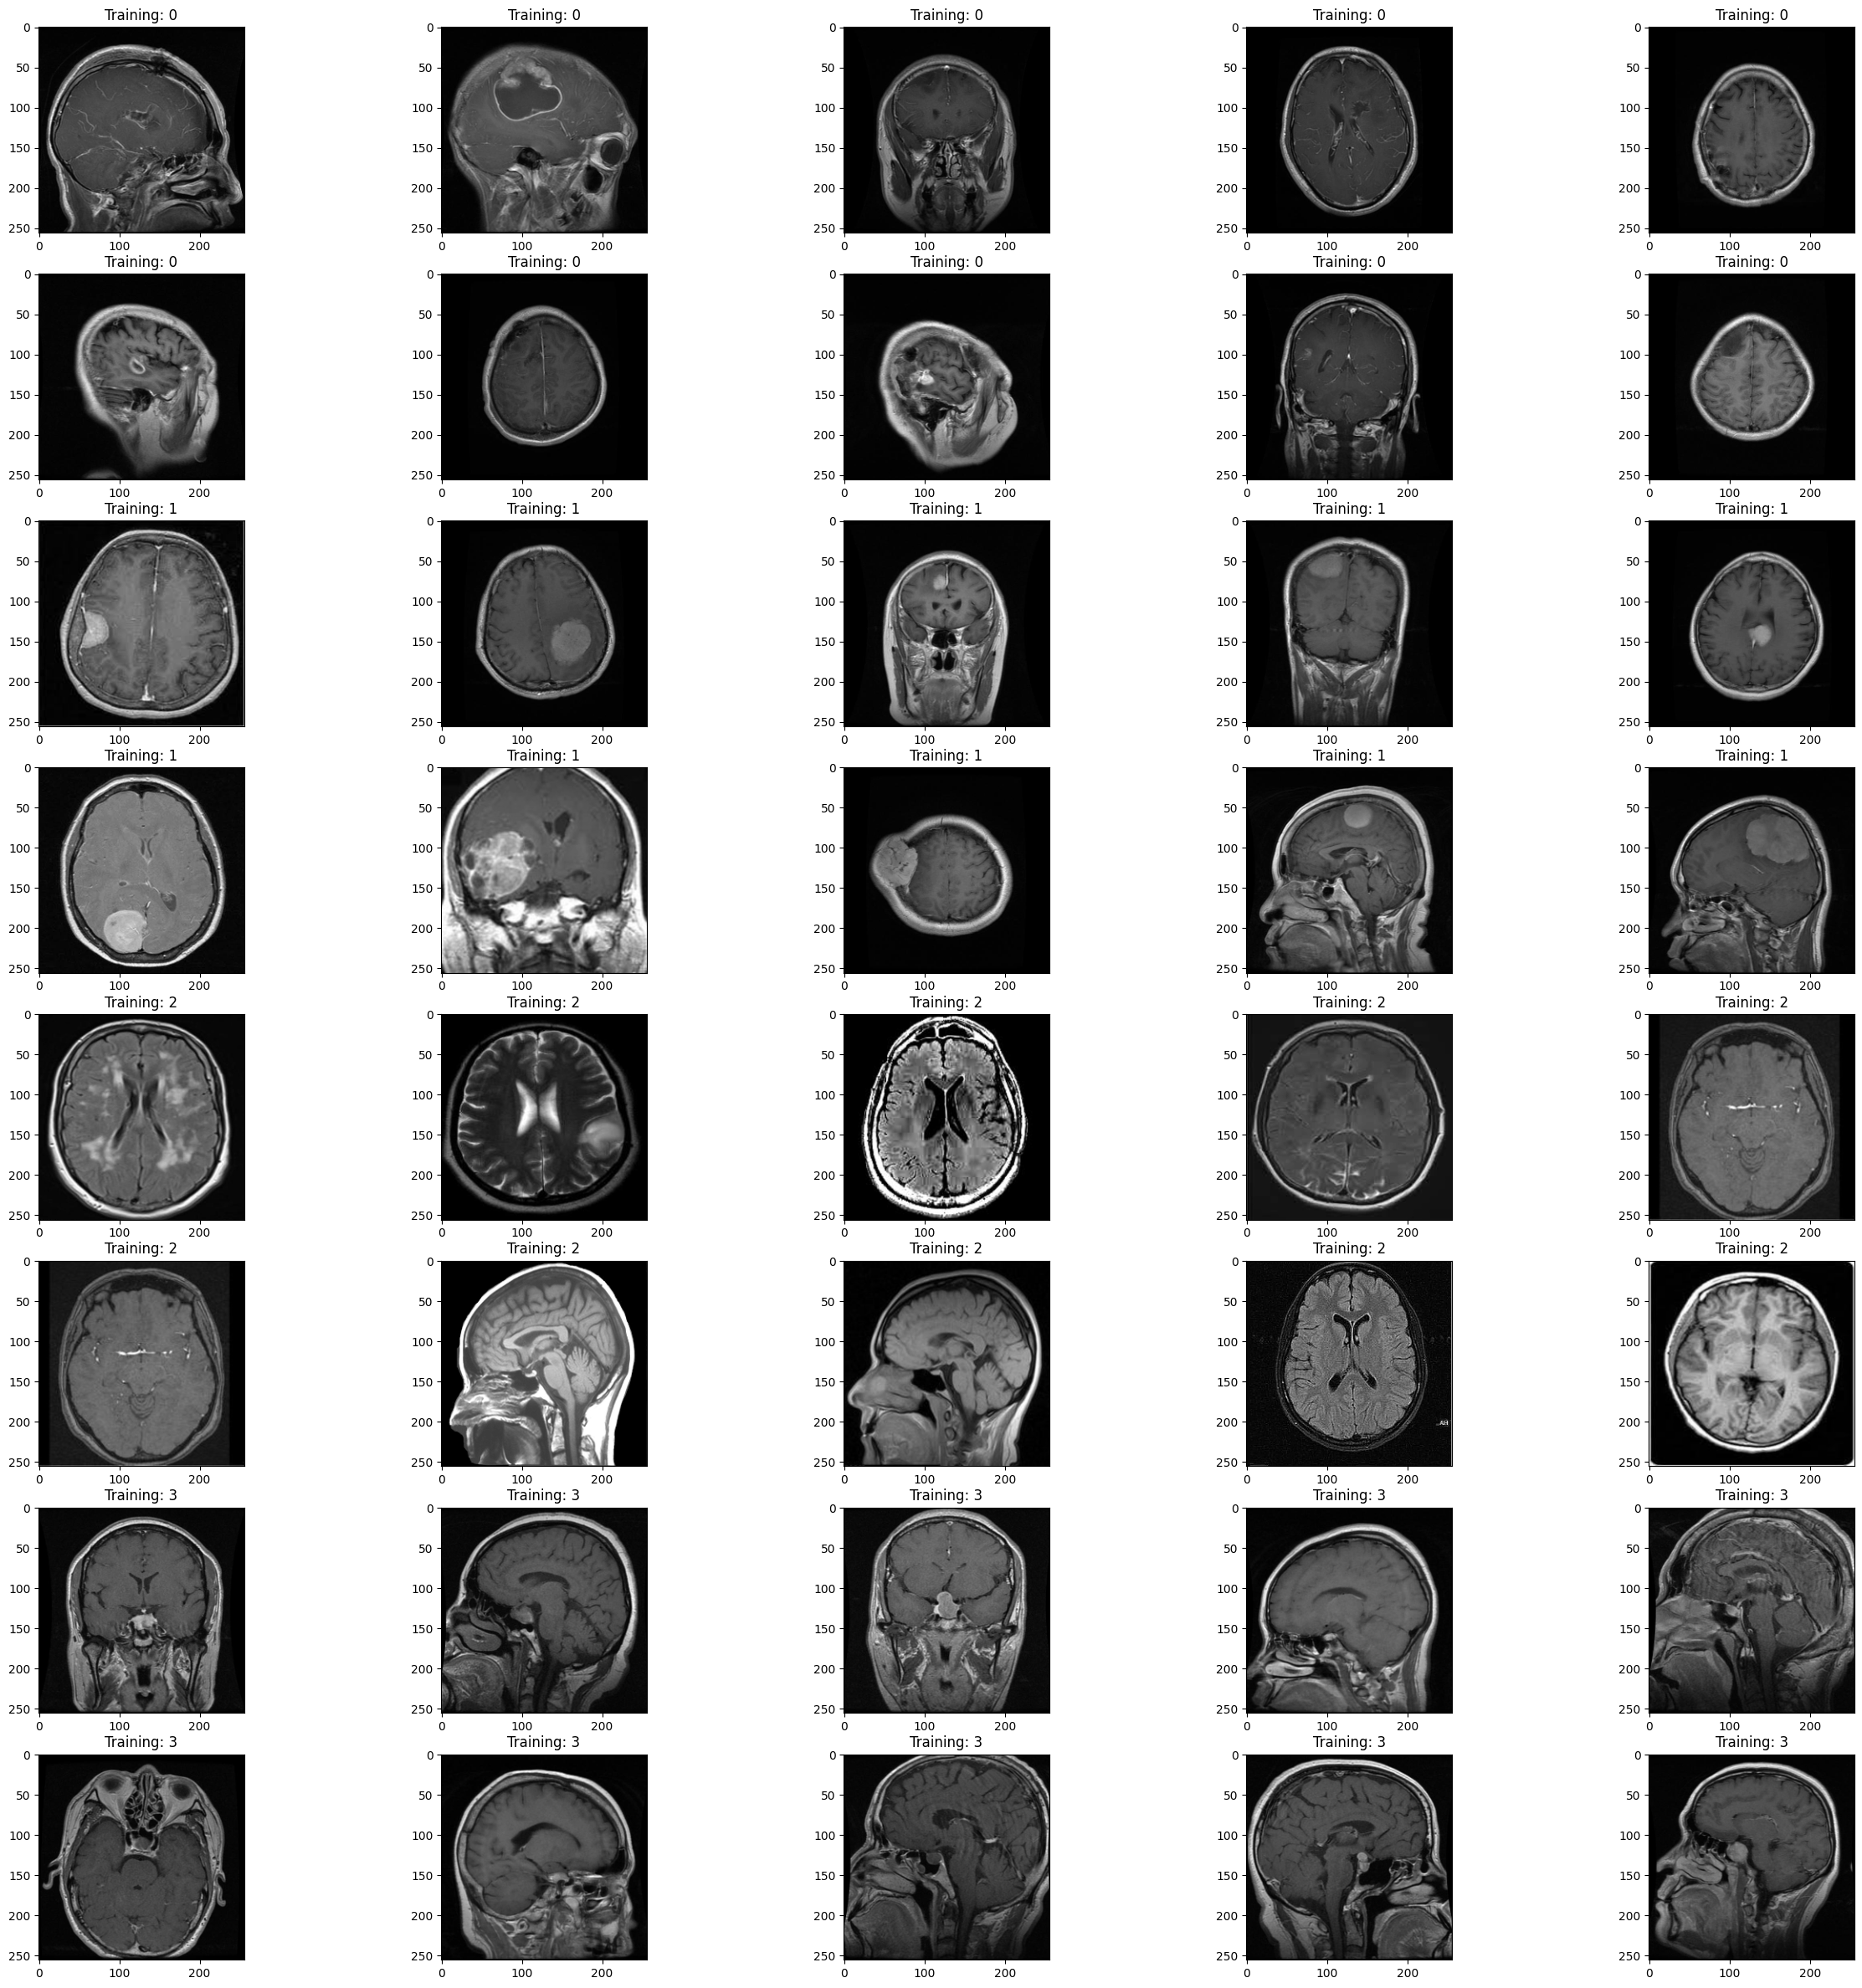

In [7]:
# Display some images from train_paths
plt.figure(figsize=(30, 30))

# Randomly select 10 indices from each set
train_random_indices_0: List[int] = np.random.choice(train_indices_0, 10, replace=False)
train_random_indices_1: List[int] = np.random.choice(train_indices_1, 10, replace=False)
train_random_indices_2: List[int] = np.random.choice(train_indices_2, 10, replace=False)
train_random_indices_3: List[int] = np.random.choice(train_indices_3, 10, replace=False)

train_plot_indices: List[int] = np.concatenate([
    train_random_indices_0, 
    train_random_indices_1, 
    train_random_indices_2, 
    train_random_indices_3,
])

# Ensure indices are unique and within bounds
train_plot_indices = list(set(train_plot_indices))
train_plot_indices.sort()

for index, (image, label) in enumerate(zip(train_paths[train_plot_indices], train_labels[train_plot_indices])):
    plt.subplot(8, 5, index + 1)
    plt.imshow(np.reshape(image, (IMG_SIZE, IMG_SIZE)), cmap=plt.cm.gray)
    plt.title(f'Training: {label}')
    
plt.show()

#### **1.4.2: Listing the Overall Class Distribution for all 4 Classes**

In [11]:
# Insert the total amount of images that appear in the dataset
TOTAL_IMAGES: int = (
    len(train_indices_0) + len(test_indices_0) + 
    len(train_indices_1) + len(test_indices_1) + 
    len(train_indices_2) + len(test_indices_2) + 
    len(train_indices_3) + len(test_indices_3) 
)

# Total number of each individual class
print(f"Number of Glioma images in dataset: {len(train_indices_0) + len(test_indices_0)}")
print(f"Number of Meningioma images in dataset: {len(train_indices_1) + len(test_indices_1)}")
print(f"Number of No Tumor images in dataset: {len(train_indices_2) + len(test_indices_2)}")
print(f"Number of Pituitary images in dataset: {len(train_indices_3) + len(test_indices_3)}\n")

# Total proportion of each individual class
print(f"Proportion of Glioma images in dataset: {100*(len(train_indices_0) + len(test_indices_0)) / TOTAL_IMAGES:.3f}%")
print(f"Proportion of Meningioma images in dataset: {100*(len(train_indices_1) + len(test_indices_1)) / TOTAL_IMAGES:.3f}%")
print(f"Proportion of No Tumor images in dataset: {100*(len(train_indices_2) + len(test_indices_2)) / TOTAL_IMAGES:.3f}%")
print(f"Proportion of Pituitary images in dataset: {100*(len(train_indices_3) + len(test_indices_3)) / TOTAL_IMAGES:.3f}%\n")

# Print total images
print(f"Total Images in Dataset: {TOTAL_IMAGES}", end="")

Number of Glioma images in dataset: 1621
Number of Meningioma images in dataset: 1645
Number of No Tumor images in dataset: 2000
Number of Pituitary images in dataset: 1757

Proportion of Glioma images in dataset: 23.081%
Proportion of Meningioma images in dataset: 23.423%
Proportion of No Tumor images in dataset: 28.478%
Proportion of Pituitary images in dataset: 25.018%

Total Images in Dataset: 7023

The information above showcases the distribution of classes in our overall dataset that we will use before splitting it into a training and testing set. The distribution of the classes is pretty proportional, with a slightly higher representation of 'No Tumor' images. Understanding distribution is important before splitting the data into training and testing sets, as it tells us how to approach the splitting process in order to maintain a representative sample in both sets.

The dataset shows a relatively balanced distribution among the different tumor types, each around 23-25%. This balance benefits us when training the model since it needs to learn how to identify and distinguish between these tumor types effectively. 

However, the 'No Tumor' category is slightly overrepresented when compared to other categories. It is not a severe imbalance, but it is still important to consider during data splitting and model training. The over-representation might reflect the real world scenario where many scans don't show tumors, which makes it a relevant aspect of the dataset. 

The above tells us that we may want to use stratified splitting to ensure that each set mirrors the distribution as closely as possible, so that the model generalizes well across all classes and performs reliably on unseen data. 

Additionally, given this distribution, metrics like precision, recall, and the F2 score (which emphasizes recall) may be important to understand how well the model performs with respect to each class considering the slight imbalance towards 'No Tumor' images. 

The dataset's class distribution provides a solid foundation for building a reliable and effective diagnostic tool. The slight over-representation of 'No Tumor' images reflects a realistic aspect of medical imaging and should be factored into both the training process and the evaluation strategy.

## **2: Preparation for Modeling and Analysis**

### **2.1: Metrics used to evaluate algorithm's performance**

Our primary goal is to be accurate and reliable in identifying brain tumors. In this case, metrics that emphasize the model's ability to correctly identify positive cases (brains with tumors) are crucial. 

Since we are performing multiclass classification in a medical context, the metrics Precision, Recall, F2 Score, and Area Under the ROC Curve (AUC-ROC) for each class can provide us with a detailed understanding of a model's performance across the various classes. We will also take a look at a confusion matrix for the model.

#### Supplementary Metrics: F2Accuracy, Precision, and Recall

Although not the main focus, accuracy, precision, and recall still offer valuable information. Accuracy gives a quick overview of overall performance, precision provides insight into the rate of false positives, and recall complements the F2 Score by highlighting the model's ability to detect actual positives.

Precision in multiclass settings is calculated separately for each class. It calculates the number of correctly-classified instances within all instances labled as that specific class. Precision is crucial when the cost of false positives is high. In this case, falsely identifying a no-tumor scan as a tumor (false positive) may lead to unnecessary stress and additional testing for the patient. However, this is not nearly as costly as false negatives when missing a case where a patient is told they do no not have a tumor or are misdiagnosed with a specific tumor when they do.

Recall in multiclass settings is calculated for each class independently. It measures a model's ability to correctly identify all instances of a particular class. Recall measures the number of correctly identified instances within the actual instances of a class. In medical scenarios such as this, it is important to seek high recall, as missing a true tumor case (false negative) has life-threatening consequences. This is extremely important.

These metrics provide a broader context to understand the model's performance, supporting the more focused insights gained from the F2 Score and Confusion Matrix. The importance of recall leads us to prefer F2 as a comparison metric of choice as well. F2 is an individual metric that does not ignore the fact that it's counterintuitive to provide people with misleading diagnoses, but emphasizes that it's way more costly to miss tumors or misdiagnose tumors. 

A confusion matrix is also important, and we should primarily look at the region in the confusion matrix where no tumor is predicted but in reality, a tumor does exist. We can then dive deeper than an F2 score with this visual to see exactly what predictions are flawed.

We personally believe that F2 score and confusion matrices will be our preferred metrics for evaluation, but the ROC curve will also be useful for checking the relationship between precision and recall. 

ROC curves can be extended for use in multiclass settings to measure the performance of a model in classifying each class against all others. The AUC-ROC is useful to understand how well a model distinguishes each tumor type from the others. 

The multiclass AUC-ROC metric provides a clear, single metric that summarizes the discrimination ability of the model. In this case, this represents insight into how well the model can differentiate between the various types of brain tumors as well as the brains with no tumors. The F2 Score's emphasis on recall is crucial for prioritizing patient safety by minimizing missed tumor detections. The Confusion Matrix provides a clear view of error types, especially false negatives, which is vital for clinical applications. The ROC curve aids in understanding the model's discriminatory power. Meanwhile, accuracy, precision, and recall serve as supplementary metrics providing a broader overview of performance.


### **2.2: Using Stratified Shuffle Split to Divide our Data into Training and Testing Datasets**


We will use Stratified Shuffle Split to divide our dataset into training and testing datasets. 

This method maintains the original proportion of each class in both the training and testing datasets. This is crucial in medical imaging datasets where class distribution may not be perfectly balanced or where each class's representation is important for accurate diagnosis. 

Additionally, using stratified shuffle split allows for repeated random sampling of the data to ensure comprehensive use of all available data. 

Stratified Shuffle Split also mimics real-world applications. In practice, a diagnostic model would be expected to perform well on any random set of patients. By creating different random splits, this method simulates this scenario and provides a realistic evaluation of how the model might perform in a clinical setting.

Finally, using stratified shuffle split also addresses overfitting concerns. With limited data, the risk of overfitting is higher. Stratified Shuffle Split mitigates this by using different subsets of data in each iteration, testing the model's generalization capability.

Stratified Shuffle Split offers a balanced approach to maximize the available data, ensures that the class distribution is maintained in each split, and provides a realistic way to evaluate the model's performance. 

In a medical context, models need to be robust, accurate, and generalizable to varied subsets of patient data. This method simulates the diversity of real-world medical scenarios and ensures that our model is not just statistically valid but also applicable in a clinical environment. 

In [13]:
# Concatenate Original Train / Test Split Into One Dataset
combined_paths = np.concatenate((train_paths, test_paths), axis = 0)
combined_labels = np.concatenate((train_labels, test_labels), axis = 0)

skf = StratifiedShuffleSplit(n_splits = 10, random_state = 42)
for train_index, test_index in skf.split(combined_paths, combined_labels):
    X_train, X_test = combined_paths[train_index], combined_paths[test_index]
    y_train, y_test = combined_labels[train_index], combined_labels[test_index]

# Train, Evaluate Model Using Train / Test (Check Shape)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6320, 256, 256) (6320,) (703, 256, 256) (703,)


In [15]:
# Encode Labels For Training
y_train_encoded = to_categorical(y_train, num_classes = NUM_CLASSES)
y_test_encoded = to_categorical(y_test, num_classes = NUM_CLASSES)

In [16]:
# Create Data Augmentation Generator
datagen = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.1,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

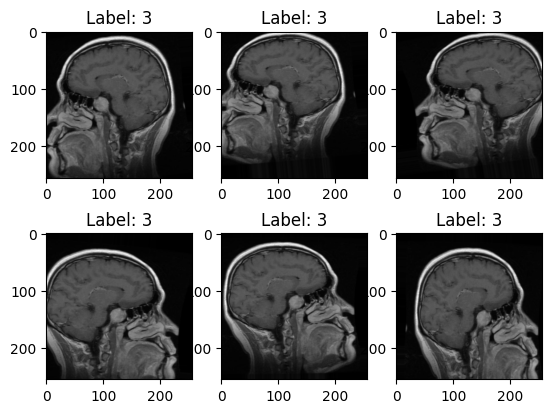

In [17]:
# Visualization Parameters
batch_size = 1
augmented_images = []
augmented_labels = []
image_array = np.expand_dims(np.array([image]), axis = -1)
label_array = np.array([label])

# Generate Augmented Images
for _ in range(6):
    for X_batch, y_batch in datagen.flow(image_array, label_array, batch_size = batch_size):
        augmented_images.append(X_batch[0])
        augmented_labels.append(y_batch[0])
        break

# Create Plotting Grid
for i in range(6):
    plt.subplot(230 + 1 + i)
    plt.imshow(augmented_images[i].reshape(256, 256), cmap = plt.get_cmap('gray'))
    plt.title("Label: {}".format(augmented_labels[i]))

# Show Plot
plt.show()

In [19]:
# Parameters
f = 4           # No. Filters
l = 4           # No. Layers
k = 3           # Kernel Size (k x k)
lam = 0.0001    # Kernel Regularization Constant (L2)

# Initialize Sequential Network
Conv1A = Sequential()

# Add Augmentations Directly
# Horizontal Flip, 10% Rotation, 10% Move, Brightness / Contrast Adjust 
Conv1A.add( RandomFlip("horizontal") )
Conv1A.add( RandomRotation(0.1) )
Conv1A.add( RandomTranslation(height_factor = 0.1, width_factor = 0.1) )
Conv1A.add( RandomBrightness(factor = 0.1, value_range = (0.0, 1.0)) )
Conv1A.add( RandomContrast(0.1) ) 

# Add Multiple Layers (Changeable)
for i in range(l):
  
    # Add Convolutional Layer, Follow With Pooling
    # Note: Loosely Following Unet Architecture
    Conv1A.add(Conv2D(filters = (f * 2 ** i),
                    input_shape = (IMG_SIZE, IMG_SIZE, 1),
                    kernel_size = (k, k), 
                    kernel_regularizer = l2(lam),
                    kernel_initializer = 'he_uniform',
                    padding = 'same', 
                    activation = 'relu',
                    data_format = 'channels_last'))
    Conv1A.add(MaxPooling2D(pool_size = (2, 2), data_format = 'channels_last'))

# Flatten After Convolutional Layers
Conv1A.add(Flatten())

# Dropout Regularization Unnecessary
Conv1A.add(Dense(NUM_CLASSES, activation = 'softmax', 
                kernel_initializer = 'glorot_uniform',
                kernel_regularizer = l2(lam)
                ))

In [20]:
# Define custom F2 score as a Keras metric
class F2Score(tf.keras.metrics.Metric):
    def __init__(self, name='f2_score', **kwargs):
        super(F2Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()
        self.beta_squared = 2**2

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return ((1 + self.beta_squared) * precision * recall / 
                (self.beta_squared * precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [21]:
# Function to plot ROC curve and calculate AUC
def plot_roc_curve(y_test, y_pred, n_classes, title):
    # Binarize the output labels for each class
    y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC and AUC for {title}')
    plt.legend(loc="lower right")
    plt.show()

In [25]:
# Train With CC, Adam
Conv1A.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy', Precision(), Recall(), F2Score()])

# Build Model With Basic Parameters (Build For Grayscale Images)
Conv1A.build((None, IMG_SIZE, IMG_SIZE, 1))
Conv1A.summary()

# Fit Model (High Patience For Full Convergence)
H1A = Conv1A.fit(X_train, y_train_encoded, 
          batch_size = 32,
          epochs = 100, 
          verbose = 1,
          validation_data = (X_test, y_test_encoded))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 256, 256, 1)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 256, 256, 1)       0         
 otation)                                                        
                                                                 
 random_translation_1 (Rand  (None, 256, 256, 1)       0         
 omTranslation)                                                  
                                                                 
 random_brightness_1 (Rando  (None, 256, 256, 1)       0         
 mBrightness)                                                    
                                                                 
 random_contrast_1 (RandomC  (None, 256, 256, 1)       0         
 ontrast)                                             

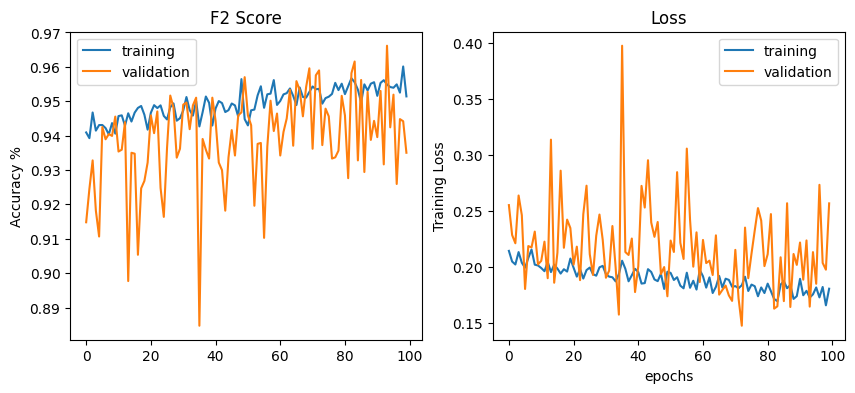

22/22 [==============================] - 0s 3ms/step


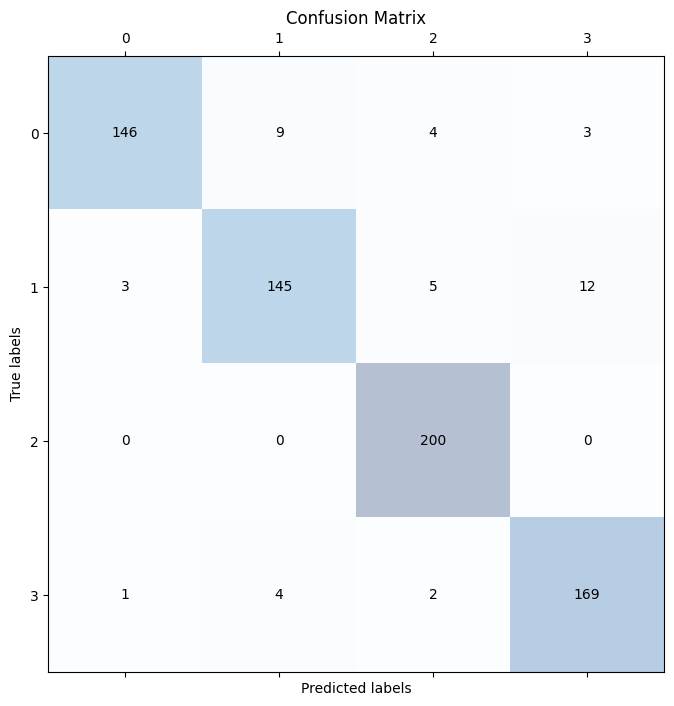

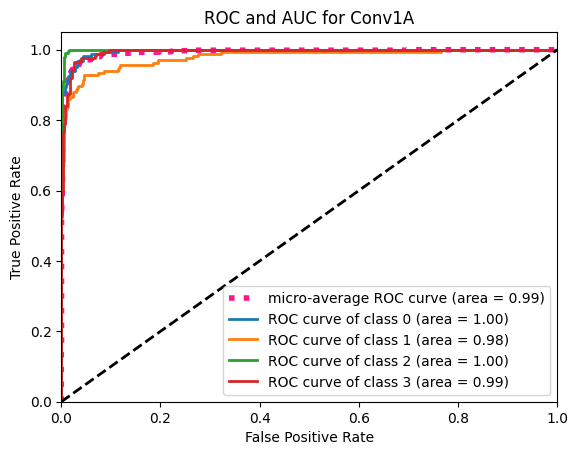

Validation Scores:
	F2 Score: [0.9147905111312866, 0.9245015382766724, 0.9327827095985413, 0.9181637167930603, 0.910647988319397, 0.9424828290939331, 0.9389269351959229, 0.9404389262199402, 0.9399032592773438, 0.9455219507217407, 0.9353644847869873, 0.9358974099159241, 0.9439066052436829, 0.897691547870636, 0.9350056648254395, 0.9347392320632935, 0.905332088470459, 0.9246575832366943, 0.926822304725647, 0.9321551322937012, 0.9458689093589783, 0.9407069683074951, 0.9470235705375671, 0.92476487159729, 0.9163573980331421, 0.9364310503005981, 0.9516358375549316, 0.9481038451194763, 0.9335804581642151, 0.936164140701294, 0.9489883780479431, 0.9496013522148132, 0.9418637752532959, 0.9487909078598022, 0.9510250687599182, 0.8847031593322754, 0.9390138983726501, 0.9358974099159241, 0.933314323425293, 0.9510250687599182, 0.9443651437759399, 0.9321551322937012, 0.9299344420433044, 0.9181637167930603, 0.9336748719215393, 0.9415954351425171, 0.9342067241668701, 0.9458689093589783, 0.946753978729248

In [30]:
# Plot Training F2 Score
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(H1A.history['f2_score'], label = 'training')

# Plot Val F2 Score
plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(H1A.history['val_f2_score'], label = 'validation')
plt.title('F2 Score')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(H1A.history['loss'], label = 'training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

# Plot Val Loss
plt.plot(H1A.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

# After training, predict classes on the test set
y_pred = Conv1A.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC and calculate AUC (CNN)
plot_roc_curve(y_test, y_pred, NUM_CLASSES, 'Conv1A')

# Print the scores
print(f"Validation Scores:\n\tF2 Score: {H1A.history['val_f2_score']}\n\tRecall: {H1A.history['val_recall_4']}")
print(f"\tPrecision: {H1A.history['val_precision_4']}\n\tAccuracy: {H1A.history['val_accuracy']}")

- F2 Score: 0.9350
- Recall: 0.9331
- Precision: 0.9425
- Accuracy: 0.9388


The confusion matrix for the brain tumor classification task indicates that the model has very few instances where it incorrectly predicts the absence of a tumor (false negatives) when there is one present (true positives), which is reflected in the high recall score of 0.9331.

Examining the confusion matrix more closely for false negatives:

- Glioma (0): There are no instances where Glioma is incorrectly predicted as 'No Tumor'.

- Meningioma (1): There are 5 instances where Meningioma is incorrectly predicted as 'No Tumor', which could have significant implications for patients if these were real-world diagnoses, as Meningioma tumors could go untreated.

- Pituitary (3): Similarly, there are 2 instances where a Pituitary tumor is misclassified as 'No Tumor'. Although fewer in number compared to Meningioma, these errors are still critical as they represent missed diagnoses.

The 'No Tumor' predictions are accurate and there are no instances where a tumor is present but the model predicts 'No Tumor', which is an ideal scenario for medical diagnosis models because it avoids missing a diagnosis of a condition that requires treatment.

The model has demonstrated a high degree of accuracy in distinguishing between four different classes of brain tumor-related conditions: Glioma, Meningioma, No Tumor, and Pituitary. An F2 score of 0.9350 indicates that the model places more emphasis on recall than precision, meaning it is more focused on minimizing false negatives. This is particularly important in medical diagnoses where failing to detect an actual condition (a false negative) is usually more critical than incorrectly diagnosing a condition (a false positive).


In [31]:
# Parameters
f = 32          # No. Filters
l = 4           # No. Layers
k = 3           # Kernel Size (k x k)
lam = 0.000001  # Kernel Regularization Constant (L2)

# Initialize Sequential Network
Conv1B = Sequential()

# Add Augmentations Directly
# Horizontal Flip, 10% Rotation, 10% Move, Brightness / Contrast Adjust 
Conv1B.add( RandomFlip("horizontal") )
Conv1B.add( RandomRotation(0.1) )
Conv1B.add( RandomTranslation(height_factor = 0.1, width_factor = 0.1) )
Conv1B.add( RandomBrightness(factor = 0.1, value_range = (0.0, 1.0)) )
Conv1B.add( RandomContrast(0.1) ) 

# Add Multiple Layers (Changeable)
for i in range(l):
  
    # Add Convolutional Layer, Follow With Pooling
    # Note: Max Filter 1024 Following Unet Architecture
    Conv1B.add(Conv2D(filters = (f * 2 ** i),
                    input_shape = (IMG_SIZE, IMG_SIZE, 1),
                    kernel_size = (k, k), 
                    kernel_regularizer = l2(lam),
                    kernel_initializer = 'he_uniform',
                    padding = 'same', 
                    activation = 'relu',
                    data_format = 'channels_last'))
    Conv1B.add(MaxPooling2D(pool_size = (2, 2), data_format = 'channels_last'))

# Flatten After Convolutional Layers
Conv1B.add(Flatten())

# Dropout Regularization Unnecessary
Conv1B.add(Dense(NUM_CLASSES, activation = 'softmax', 
                kernel_initializer = 'glorot_uniform',
                kernel_regularizer = l2(lam)
                ))

In [32]:
# Train With CC, Adam
Conv1B.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy', Precision(), Recall(), F2Score()])

# Build Model With Basic Parameters (Build For Grayscale Images)
Conv1B.build((None, IMG_SIZE, IMG_SIZE, 1))
Conv1B.summary()

# Fit Model (High Patience For Full Convergence)
H1B = Conv1B.fit(X_train, y_train_encoded, 
          batch_size = 128,
          epochs = 100, 
          verbose = 1,
          validation_data = (X_test, y_test_encoded))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 256, 256, 1)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 256, 256, 1)       0         
 otation)                                                        
                                                                 
 random_translation_2 (Rand  (None, 256, 256, 1)       0         
 omTranslation)                                                  
                                                                 
 random_brightness_2 (Rando  (None, 256, 256, 1)       0         
 mBrightness)                                                    
                                                                 
 random_contrast_2 (RandomC  (None, 256, 256, 1)       0         
 ontrast)                                             

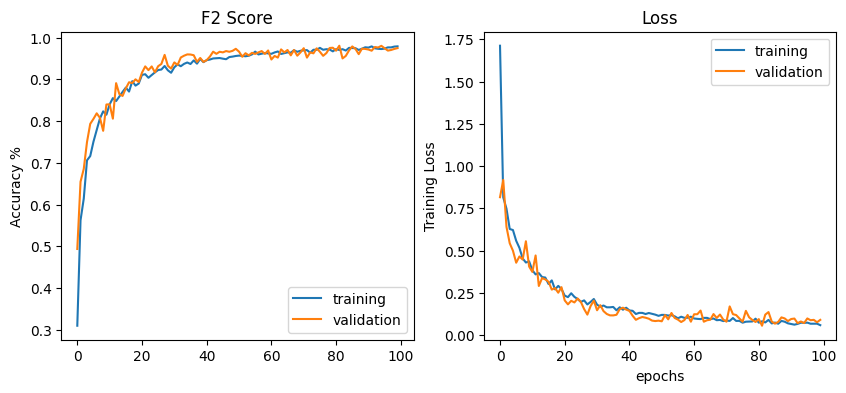

22/22 [==============================] - 0s 5ms/step


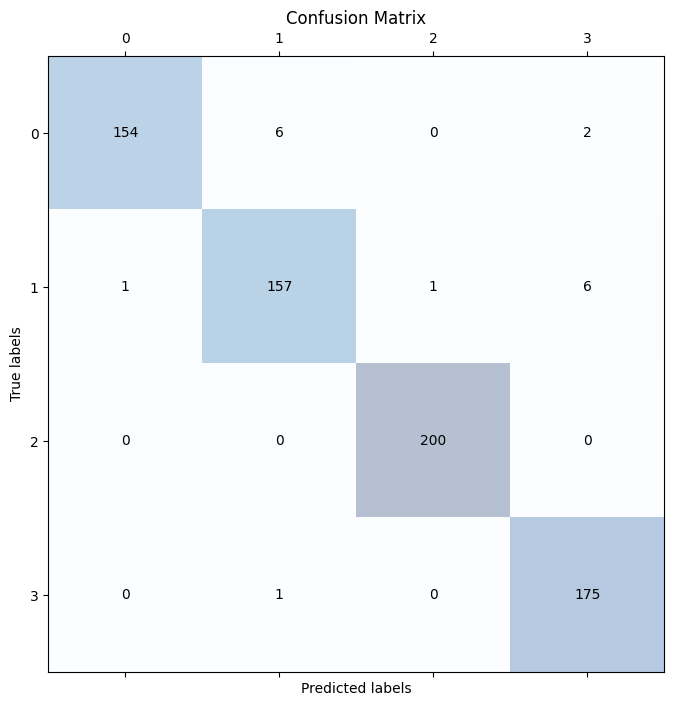

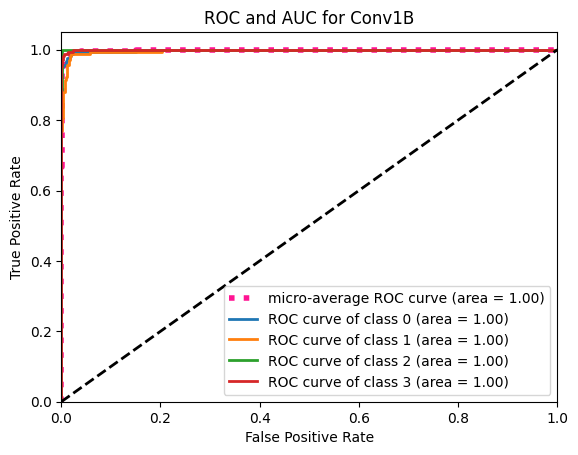

Validation Scores:
	F2 Score: [0.49376946687698364, 0.6547447443008423, 0.6855791807174683, 0.7498552203178406, 0.7934908866882324, 0.8053788542747498, 0.8187050819396973, 0.8079356551170349, 0.7767831087112427, 0.839804470539093, 0.840275764465332, 0.805944561958313, 0.8910183310508728, 0.8648338913917542, 0.8603384494781494, 0.8784940242767334, 0.893112301826477, 0.8911740183830261, 0.9001426100730896, 0.8936716914176941, 0.9160958528518677, 0.9310934543609619, 0.9221779108047485, 0.9309951066970825, 0.9169993996620178, 0.9316238760948181, 0.9369651675224304, 0.9586895108222961, 0.9326869249343872, 0.9258202910423279, 0.9407069683074951, 0.9344728589057922, 0.9524487257003784, 0.9567198157310486, 0.9598404765129089, 0.9595671892166138, 0.9578707218170166, 0.9419465065002441, 0.9512959122657776, 0.9418637752532959, 0.9461385607719421, 0.9546878933906555, 0.9663626551628113, 0.9612646102905273, 0.9661354422569275, 0.9647125601768494, 0.9678336977958679, 0.9661354422569275, 0.9683850407

In [35]:
# Plot the training F2 score
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(H1B.history['f2_score'], label = 'training')

# Plot the Validation F2 Score
plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(H1B.history['val_f2_score'], label = 'validation')
plt.title('F2 Score')
plt.legend()

# Plot the Training Loss
plt.subplot(1, 2, 2)
plt.plot(H1B.history['loss'], label = 'training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

# Plot the Val Loss
plt.plot(H1B.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

# After training, predict classes on the test set
y_pred = Conv1B.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC and calculate AUC (CNN)
plot_roc_curve(y_test, y_pred, NUM_CLASSES, 'Conv1B')

# Print the scores
print(f"Validation Scores:\n\tF2 Score: {H1B.history['val_f2_score']}\n\tRecall: {H1B.history['val_recall_6']}")
print(f"\tPrecision: {H1B.history['val_precision_6']}\n\tAccuracy: {H1B.history['val_accuracy']}")

- F2 Score: 0.9750
- Recall: 0.9743
- Precision: 0.9772
- Accuracy: 0.9758

The second confusion matrix and the associated metrics indicate an even higher performance of the model in classifying brain tumors compared to the first one.

- Glioma (0): The model correctly identified Glioma 154 times, and there are no instances where Glioma is incorrectly predicted as 'No Tumor'. This is an improvement compared to the previous model, which had 4 instances of false negatives for Glioma.

- Meningioma (1): It correctly identified Meningioma 157 times, with only 1 instance incorrectly predicted as 'No Tumor'. Compared to the previous model, which had 5 false negatives for Meningioma, this represents a significant improvement.

- No Tumor (2): The model perfectly classified all 200 instances with no false negatives, which is consistent with the previous model's performance for this class.

- Pituitary (3): The model identified Pituitary tumors correctly 175 times, with only 1 case misclassified as 'No Tumor'. This is an improvement compared to the previous model, which had 2 false negatives for Pituitary.

The F2 score for this model is 0.9750, which, given that the F2 score gives more weight to recall than precision, indicates that the model is very effective at minimizing false negatives. It is an improvement over the previous model's F2 score of 0.9350, indicating better overall performance with respect to the balance between recall and precision. The recall rate of 0.9743 is a slight improvement over the previous recall rate of 0.9331, and the precision rate of 0.9772 is also an improvement over the previous precision rate of 0.9425.

The accuracy of this model is 0.9758, which is a small but notable improvement from the previous model's accuracy of 0.9388.



Number of Filters (f): The number of filters in a convolutional layer determines the number of unique feature detectors that will be applied to the input data. Increasing the number of filters can allow the network to capture a wider array of features from the input data. This can potentially lead to better model performance, as the network can learn more complex and subtle patterns in the data. However, it also increases the number of trainable parameters, which can lead to a risk of overfitting if not managed properly (e.g., with sufficient training data or regularization).

Kernel Regularization Constant (lam): Regularization is used to prevent overfitting by penalizing large weights in the model. A smaller lambda (λ) means less regularization, allowing the weights to grow larger if needed to minimize the loss function. This can lead to a more flexible model that fits the training data more closely. Conversely, a larger λ imposes stronger penalties on large weights, leading to a simpler model that may generalize better but potentially at the cost of not fitting the training data as closely.

Batch Size: While the batch size does not directly affect the model's capacity to learn, it influences the training dynamics. Larger batch sizes offer more stable gradients from batch to batch, which can lead to more stable convergence. However, smaller batch sizes often provide a regularizing effect and can escape local minima due to the noise they introduce in the gradient estimation. Finding the right batch size is often a balance between computational efficiency and the quality of the convergence.

When comparing Conv1A and Conv1B, the increased number of filters in Conv1B allows the model to potentially learn more complex features at each layer. The reduced regularization term in Conv1B (a smaller lam value) suggests that the weights are allowed to grow larger, giving the model more flexibility during training. This could mean that Conv1B is more prone to overfitting than Conv1A; however, if the validation accuracy has also improved, it indicates that the model is still generalizing well to unseen data.

In [36]:
# Parameters
f = 32          # No. Filters
l = 6           # No. Layers
k = 5           # Kernel Size (k x k)
lam = 0.0001    # Kernel Regularization Constant (L2)

# Initialize Sequential Network
Conv2A = Sequential()

# Add Augmentations Directly
# Horizontal Flip, 10% Rotation, 10% Move, Brightness / Contrast Adjust 
Conv2A.add( RandomFlip("horizontal") )
Conv2A.add( RandomRotation(0.1) )
Conv2A.add( RandomTranslation(height_factor = 0.1, width_factor = 0.1) )
Conv2A.add( RandomBrightness(factor = 0.1, value_range = (0.0, 1.0)) )
Conv2A.add( RandomContrast(0.1) ) 

# Add Multiple Layers (Changeable)
for i in range(l):
  
    # Add Convolutional Layer, Follow With Pooling
    # Note: Loosely Following Unet Architecture
    Conv2A.add(Conv2D(filters = (f * 2 ** i),
                    input_shape = (IMG_SIZE, IMG_SIZE, 1),
                    kernel_size = (k, k), 
                    kernel_regularizer = l2(lam),
                    kernel_initializer = 'he_uniform',
                    padding = 'same', 
                    activation = 'relu',
                    data_format = 'channels_last'))
    Conv2A.add(MaxPooling2D(pool_size = (2, 2), data_format = 'channels_last'))

# Flatten After Convolutional Layers
Conv2A.add(Flatten())

# Same Final Dense Layer
Conv2A.add(Dense(NUM_CLASSES, activation = 'softmax', 
                kernel_initializer = 'glorot_uniform',
                kernel_regularizer = l2(lam)
                ))

In [37]:
# Train With CC, Adam
Conv2A.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy', Precision(), Recall(), F2Score()])

# Build Model With Basic Parameters (Build For Grayscale Images)
Conv2A.build((None, IMG_SIZE, IMG_SIZE, 1))
Conv2A.summary()

# Fit Model (High Patience For Full Convergence)
H2A = Conv2A.fit(X_train, y_train_encoded, 
          batch_size = 128,
          epochs = 100, 
          verbose = 1,
          validation_data = (X_test, y_test_encoded))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 256, 256, 1)       0         
                                                                 
 random_rotation_3 (RandomR  (None, 256, 256, 1)       0         
 otation)                                                        
                                                                 
 random_translation_3 (Rand  (None, 256, 256, 1)       0         
 omTranslation)                                                  
                                                                 
 random_brightness_3 (Rando  (None, 256, 256, 1)       0         
 mBrightness)                                                    
                                                                 
 random_contrast_3 (RandomC  (None, 256, 256, 1)       0         
 ontrast)                                             

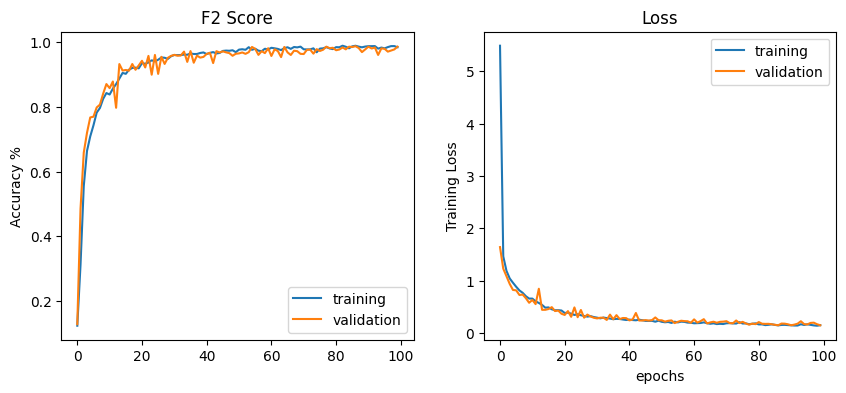

22/22 [==============================] - 1s 8ms/step


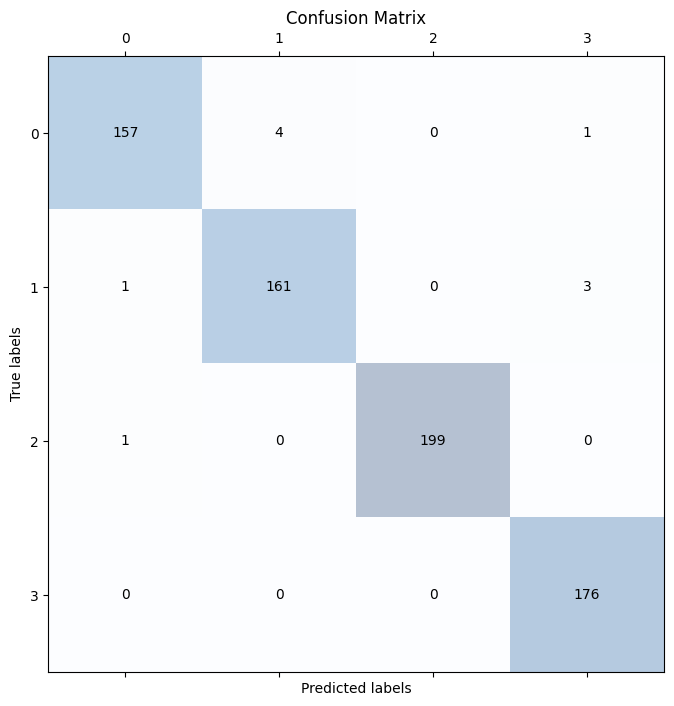

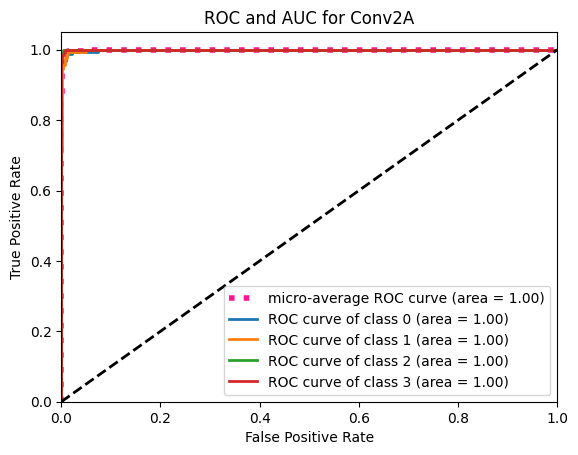

Validation Scores:
	F2 Score: [0.1287262886762619, 0.4853031039237976, 0.6584302186965942, 0.719685971736908, 0.7671113014221191, 0.7695627212524414, 0.7979798913002014, 0.8067758083343506, 0.8407333493232727, 0.8702486157417297, 0.8576746582984924, 0.8781465888023376, 0.79701828956604, 0.9320582151412964, 0.9120752215385437, 0.9137634634971619, 0.9116809964179993, 0.9321551322937012, 0.9144079685211182, 0.9278791546821594, 0.9421322345733643, 0.9215405583381653, 0.9572649598121643, 0.8992291688919067, 0.9601140022277832, 0.901569128036499, 0.954416036605835, 0.9324209094047546, 0.9512959122657776, 0.9572649598121643, 0.9603875279426575, 0.9578707218170166, 0.9584164023399353, 0.9704041481018066, 0.9387463927268982, 0.9721036553382874, 0.936164140701294, 0.9581435322761536, 0.951906681060791, 0.9541441798210144, 0.963289737701416, 0.9666857719421387, 0.9350981712341309, 0.9718270897865295, 0.9678336977958679, 0.9712331891059875, 0.9681093692779541, 0.9658120274543762, 0.957598149776458

In [40]:
# Plot the training F2 Score
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(H2A.history['f2_score'], label = 'training')

# Plot the Val F2 Score
plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(H2A.history['val_f2_score'], label = 'validation')
plt.title('F2 Score')
plt.legend()

# Plot the Loss
plt.subplot(1, 2, 2)
plt.plot(H2A.history['loss'], label = 'training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

# Plot the Validation Loss
plt.plot(H2A.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

# After training, predict classes on the test set
y_pred = Conv2A.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC and calculate AUC (CNN)
plot_roc_curve(y_test, y_pred, NUM_CLASSES, 'Conv2A')

# Print the scores
print(f"Validation Scores:\n\tF2 Score: {H2A.history['val_f2_score']}\n\tRecall: {H2A.history['val_recall_8']}")
print(f"\tPrecision: {H2A.history['val_precision_8']}\n\tAccuracy: {H2A.history['val_accuracy']}")

- F2 Score: 0.9858
- Recall: 0.9858
- Precision: 0.9858
- Accuracy: 0.9858

The confusion matrix for the different architecture shows exceptional performance with a high F2 score, recall, precision, and accuracy, all at 0.9858. This indicates a very balanced model with a strong performance in both identifying true positives (high recall) and minimizing false positives (high precision), which is further emphasized by the F2 score showing a bias towards recall. In the Confusion Matrix:

- Glioma (0): The model has very few false positives, with only 4 cases where other conditions are incorrectly predicted as Glioma.

- Meningioma (1): There is only 1 false positive, where a non-Meningioma case is misclassified as Meningioma.

- No Tumor (2): Similarly, there is 1 case where a tumor is incorrectly predicted as 'No Tumor', indicating a rare instance of false positivity for the absence of a tumor.

- Pituitary (3): There are no false positives, showing a perfect precision rate for this class.

The fact that the F2 score, recall, precision, and accuracy all have the same value of 0.9858 is an indication of the model's consistency across these metrics. It suggests that not only is the model good at identifying positive cases (as indicated by the high recall), but it is also very accurate in its predictions (as indicated by the high precision), without sacrificing one for the other. This balance is particularly important in medical imaging, where both missing a condition (false negative) and incorrectly diagnosing a condition (false positive) can have serious implications. However, recall is still more important nonetheless, but it is very good. 

The F2 score being equal to recall and precision underscores the model's robustness. It manages to maintain this balance even when extra importance is placed on recall, which is crucial in medical diagnosis to ensure that as many true cases as possible are identified.

Conv2A Model Architecture and Parameters:

Filters (f): Conv2A starts with 32 filters in the first convolutional layer and doubles this number with each subsequent layer. This is indicative of a deep and complex network capable of learning a rich variety of features from the input data.

Layers (l): With 6 layers, Conv2A is designed to capture a hierarchy of features, from simple to complex, as the depth increases.

Kernel Size (k): The kernel size of 5x5 in Conv2A allows the model to capture more spatial information and potentially learn more complex features in the input space.

Regularization Constant (lam): The regularization constant of 0.0001 suggests a moderate level of regularization, aiming to prevent overfitting while still allowing the model to learn complex patterns.

Architecture Specifics: Conv2A uses he_uniform initialization, which is suited for layers with ReLU activation, and follows a pattern loosely based on the U-Net architecture.

Conv2B Model Architecture and Parameters:

Filters (f): Conv2B starts with a much smaller number of filters (4) and similarly doubles them with each layer. This design implies a more gradual and constrained approach to feature learning, potentially requiring less computational resources.

Layers (l): Conv2B matches Conv2A in depth with 6 layers, which means it is also structured to process features hierarchically.

Kernel Size (k): Conv2B employs the same kernel size of 5x5, which is consistent with the idea of capturing larger receptive fields in the input data.

Regularization Constant (lam): With a much smaller lambda of 0.0000001, Conv2B places a weaker constraint on the weights, possibly leading to a more flexible but also more overfit-prone model.

Dropout Regularization: Conv2B introduces a dropout layer with a rate of 0.25, which is a significant addition. Dropout helps in preventing overfitting by randomly disabling a subset of neurons, thus forcing the network to learn more robust features.

Architecture Specifics: Conv2B shares the use of he_uniform initialization and the U-Net-like architecture with Conv2A.

Impact on Model Performance:

Conv2A is designed to be a more powerful model in terms of capacity. It can learn more detailed and complex feature representations, which may lead to better performance on large and complex datasets. However, the moderate regularization and lack of dropout could make it more susceptible to overfitting, especially if the training data is not extensive enough to support such a complex model.

Conv2B takes a more conservative approach to feature learning and includes dropout to mitigate the risk of overfitting. This model may be more suitable for smaller datasets or when the computational resources are a limiting factor. It trades off some capacity for complexity in favor of potentially better generalization.

In [41]:
# Parameters
f = 4           # No. Filters
l = 6           # No. Layers
k = 5           # Kernel Size (k x k)
lam = 0.0000001 # Kernel Regularization Constant (L2)

# Initialize Sequential Network
Conv2B = Sequential()

# Add Augmentations Directly
# Horizontal Flip, 10% Rotation, 10% Move, Brightness / Contrast Adjust 
Conv2B.add( RandomFlip("horizontal") )
Conv2B.add( RandomRotation(0.1) )
Conv2B.add( RandomTranslation(height_factor = 0.1, width_factor = 0.1) )
Conv2B.add( RandomBrightness(factor = 0.1, value_range = (0.0, 1.0)) )
Conv2B.add( RandomContrast(0.1) ) 

# Add Multiple Layers (Changeable)
for i in range(l):
  
    # Add Convolutional Layer, Follow With Pooling
    # Note: Loosely Following Unet Architecture
    Conv2B.add(Conv2D(filters = (f * 2 ** i),
                    input_shape = (IMG_SIZE, IMG_SIZE, 1),
                    kernel_size = (k, k), 
                    kernel_regularizer = l2(lam),
                    kernel_initializer = 'he_uniform',
                    padding = 'same', 
                    activation = 'relu',
                    data_format = 'channels_last'))
    Conv2B.add(MaxPooling2D(pool_size = (2, 2), data_format = 'channels_last'))

# Flatten After Convolutional Layers
Conv2B.add(Flatten())

# Added Dropout Regularization - Intepret Model Changes
Conv2B.add(Dropout(0.25))
Conv2B.add(Dense(NUM_CLASSES, activation = 'softmax', 
                kernel_initializer = 'glorot_uniform',
                kernel_regularizer = l2(lam)
                ))

In [42]:
# Train With CC, Adam
Conv2B.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy', Precision(), Recall(), F2Score()])

# Build Model With Basic Parameters (Build For Grayscale Images)
Conv2B.build((None, IMG_SIZE, IMG_SIZE, 1))
Conv2B.summary()

# Fit Model (High Patience For Full Convergence)
H2B = Conv2B.fit(X_train, y_train_encoded, 
          batch_size = 128,
          epochs = 100, 
          verbose = 1,
          validation_data = (X_test, y_test_encoded))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_4 (RandomFlip)  (None, 256, 256, 1)       0         
                                                                 
 random_rotation_4 (RandomR  (None, 256, 256, 1)       0         
 otation)                                                        
                                                                 
 random_translation_4 (Rand  (None, 256, 256, 1)       0         
 omTranslation)                                                  
                                                                 
 random_brightness_4 (Rando  (None, 256, 256, 1)       0         
 mBrightness)                                                    
                                                                 
 random_contrast_4 (RandomC  (None, 256, 256, 1)       0         
 ontrast)                                             

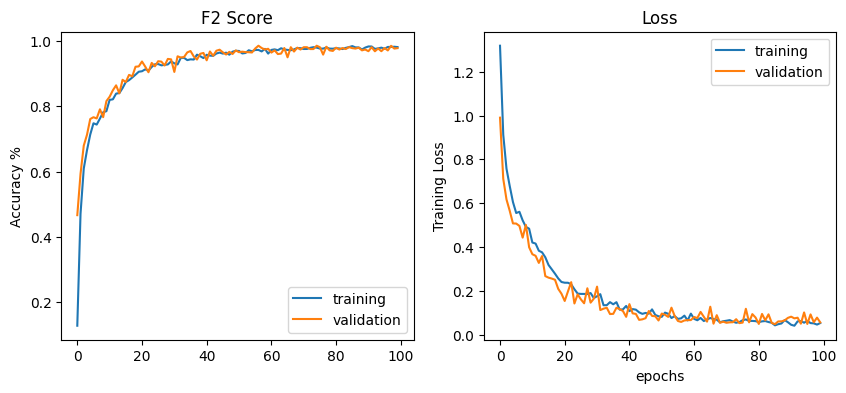

22/22 [==============================] - 0s 8ms/step


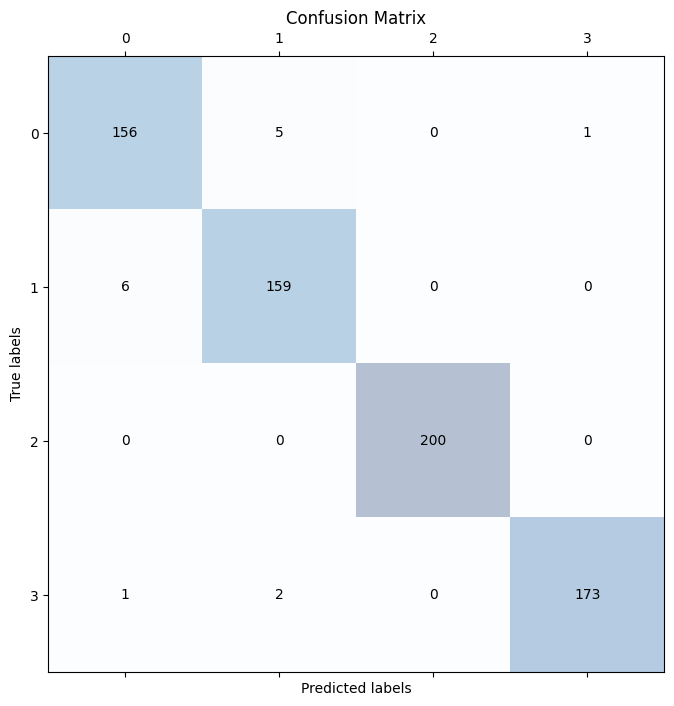

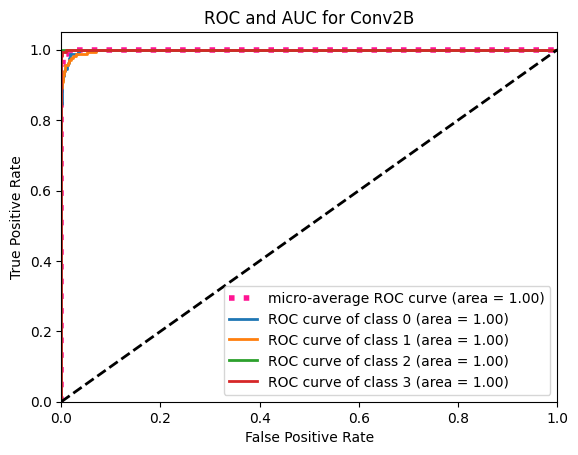

Validation Scores:
	F2 Score: [0.46603715419769287, 0.5929149985313416, 0.679411768913269, 0.7128159403800964, 0.761090099811554, 0.7666761875152588, 0.7628836035728455, 0.7909116744995117, 0.7668007016181946, 0.8160621523857117, 0.8295129537582397, 0.8493268489837646, 0.8644793629646301, 0.840011477470398, 0.8815112113952637, 0.8746774196624756, 0.8965222835540771, 0.8921933174133301, 0.9215405583381653, 0.9225934743881226, 0.9375891089439392, 0.9219151139259338, 0.904666543006897, 0.933314323425293, 0.9228572249412537, 0.9384791254997253, 0.9372325539588928, 0.9253986477851868, 0.9455995559692383, 0.9441754221916199, 0.9055903553962708, 0.9536008834838867, 0.949871838092804, 0.9512959122657776, 0.9655369520187378, 0.9698092341423035, 0.9532630443572998, 0.9435575604438782, 0.9612646102905273, 0.9638382792472839, 0.9413272738456726, 0.9683850407600403, 0.9552960991859436, 0.9706802368164062, 0.9738041162490845, 0.9658120274543762, 0.9590210914611816, 0.9672363996505737, 0.960717380046

In [43]:
# Plot training F2
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(H2B.history['f2_score'], label = 'training')

# Plot validation F2 Score
plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(H2B.history['val_f2_score'], label = 'validation')
plt.title('F2 Score')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(H2B.history['loss'], label = 'training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

# Plot Validation Loss
plt.plot(H2B.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

# After training, predict classes on the test set
y_pred = Conv2B.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC and calculate AUC (CNN)
plot_roc_curve(y_test, y_pred, NUM_CLASSES, 'Conv2B')

# Print the scores
print(f"Validation Scores:\n\tF2 Score: {H2B.history['val_f2_score']}\n\tRecall: {H2B.history['val_recall_10']}")
print(f"\tPrecision: {H2B.history['val_precision_10']}\n\tAccuracy: {H2B.history['val_accuracy']}")

- F2 Score: 0.9787
- Recall: 0.9787
- Precision: 0.9787
- Accuracy: 0.9787

Comparing the current model's (Conv2B) confusion matrix and performance metrics with the previous one (Conv2A), we observe the following:

- Glioma (0): Both models are very effective in classifying Glioma. The current model has 156 true positives with 5 false negatives, while the previous model had 157 true positives and 4 false negatives. They are nearly identical in performance for this category.

- Meningioma (1): The current model slightly underperforms compared to the previous model for Meningioma, with 159 true positives against 161 from the previous model and 6 false negatives compared to only 1 in the previous model. This could be an area of focus for further refinement.

- No Tumor (2): Both models show exemplary performance for 'No Tumor' cases, with perfect classification in the current model and only 1 false negative in the previous model.

- Pituitary (3): The current model shows a slight improvement in classifying Pituitary tumors with 173 true positives and 3 false negatives, compared to 175 true positives and 3 false negatives in the previous model.

The F2 score, which emphasizes the importance of recall, is 0.9787 for the current model, which is marginally lower than the 0.9858 of the previous model. This suggests that the previous model was slightly more effective in terms of balancing the recall and precision while placing a higher emphasis on recall.

It is worth noting that in both models, the F2 score, recall, precision, and accuracy metrics are identically high and have very close values, which indicates both models are well-optimized across these metrics. However, the previous model has a slight edge in performance across all categories.

In [44]:
# Parameters
f = 4           # No. Filters
l = 6           # No. Layers
k = 5           # Kernel Size (k x k)
lam = 0.0000001 # Kernel Regularization Constant (L2)

# Initialize Sequential Network
Conv2C = Sequential()

# Add Augmentations Directly
# Horizontal Flip, 10% Rotation, 10% Move, Brightness / Contrast Adjust 
Conv2C.add( RandomFlip("horizontal") )
Conv2C.add( RandomRotation(0.1) )
Conv2C.add( RandomTranslation(height_factor = 0.1, width_factor = 0.1) )
Conv2C.add( RandomBrightness(factor = 0.1, value_range = (0.0, 1.0)) )
Conv2C.add( RandomContrast(0.1) ) 

# Add Multiple Layers (Changeable)
for i in range(l):
  
    # Add Convolutional Layer, Follow With Pooling
    # Note: Loosely Following Unet Architecture
    Conv2C.add(Conv2D(filters = (f * 2 ** i),
                    input_shape = (IMG_SIZE, IMG_SIZE, 1),
                    kernel_size = (k, k), 
                    kernel_regularizer = l2(lam),
                    kernel_initializer = 'he_uniform',
                    padding = 'same', 
                    activation = 'relu',
                    data_format = 'channels_last'))
    Conv2C.add(MaxPooling2D(pool_size = (2, 2), data_format = 'channels_last'))

# Flatten After Convolutional Layers
Conv2C.add(Flatten())

# Added Dropout Regularization - Intepret Model Changes
Conv2C.add(Dropout(0.75))
Conv2C.add(Dense(NUM_CLASSES, activation = 'softmax', 
                kernel_initializer = 'glorot_uniform',
                kernel_regularizer = l2(lam)
                ))

In [45]:
# Train With CC, Adam
Conv2C.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy', Precision(), Recall(), F2Score()])

# Build Model With Basic Parameters (Build For Grayscale Images)
Conv2C.build((None, IMG_SIZE, IMG_SIZE, 1))
Conv2C.summary()

# Fit Model (High Patience For Full Convergence)
H2C = Conv2C.fit(X_train, y_train_encoded, 
          batch_size = 128,
          epochs = 100, 
          verbose = 1,
          validation_data = (X_test, y_test_encoded))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_5 (RandomFlip)  (None, 256, 256, 1)       0         
                                                                 
 random_rotation_5 (RandomR  (None, 256, 256, 1)       0         
 otation)                                                        
                                                                 
 random_translation_5 (Rand  (None, 256, 256, 1)       0         
 omTranslation)                                                  
                                                                 
 random_brightness_5 (Rando  (None, 256, 256, 1)       0         
 mBrightness)                                                    
                                                                 
 random_contrast_5 (RandomC  (None, 256, 256, 1)       0         
 ontrast)                                             

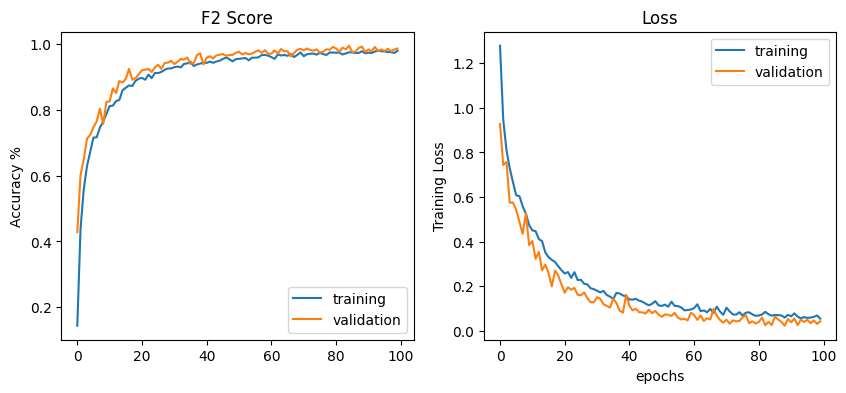

22/22 [==============================] - 0s 4ms/step


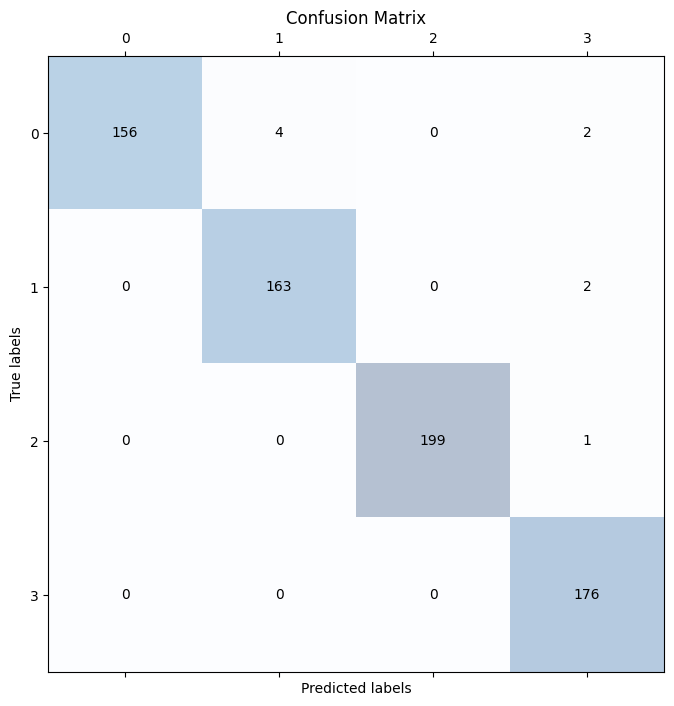

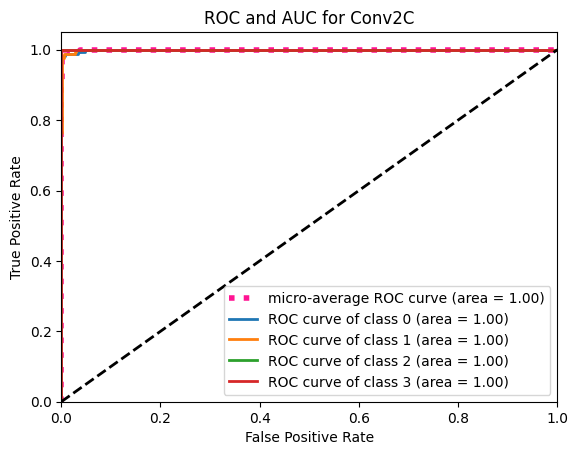

Validation Scores:
	F2 Score: [0.4281681180000305, 0.6021409034729004, 0.6496350169181824, 0.7128339409828186, 0.7244071364402771, 0.7481115460395813, 0.7654392719268799, 0.8041355609893799, 0.7571802139282227, 0.824727475643158, 0.8261369466781616, 0.8659058809280396, 0.8519473075866699, 0.8883176445960999, 0.8833619356155396, 0.895052969455719, 0.9254499077796936, 0.8922944664955139, 0.8969956636428833, 0.9087018370628357, 0.9211652874946594, 0.9227039217948914, 0.9251855611801147, 0.9155732989311218, 0.9299344420433044, 0.9376785755157471, 0.9252923130989075, 0.9432886838912964, 0.9441754221916199, 0.9501424431800842, 0.9400856494903564, 0.946753978729248, 0.9555681347846985, 0.9532630443572998, 0.9601140022277832, 0.9399032592773438, 0.9430199861526489, 0.9672830700874329, 0.972657322883606, 0.9384791254997253, 0.9592939615249634, 0.9638382792472839, 0.9569923877716064, 0.9664105772972107, 0.9683850407600403, 0.9704041481018066, 0.9649373292922974, 0.9672363996505737, 0.96783369779

In [46]:
# Plot Training F2 score
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(H2C.history['f2_score'], label = 'training')

# Plot Val F2 score
plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(H2C.history['val_f2_score'], label = 'validation')
plt.title('F2 Score')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(H2C.history['loss'], label = 'training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

# Plot Validation Loss
plt.plot(H2C.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

# After training, predict classes on the test set
y_pred = Conv2C.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC and calculate AUC (CNN)
plot_roc_curve(y_test, y_pred, NUM_CLASSES, 'Conv2C')

# Print the scores
print(f"Validation Scores:\n\tF2 Score: {H2C.history['val_f2_score']}\n\tRecall: {H2C.history['val_recall_12']}")
print(f"\tPrecision: {H2C.history['val_precision_12']}\n\tAccuracy: {H2C.history['val_accuracy']}")

- F2 Score: 0.9872
- Recall: 0.9872
- Precision: 0.9872
- Accuracy: 0.9872

The third model, which includes dropout layers, demonstrates even further improved performance compared to the earlier models, as reflected in the confusion matrix and the identical F2 score, recall, precision, and accuracy of 0.9872. From the confusion matrix:

- Glioma (0): The third model has 156 true positives and 4 false negatives, which is identical to the second model's performance for Glioma, suggesting consistent robustness in this category.

- Meningioma (1): The third model shows a substantial improvement, with 163 true positives and no false negatives, compared to the second model, which had 161 true positives and 1 false negative. This indicates enhanced sensitivity and reliability for Meningioma classification.

- No Tumor (2): Both the third and the second models display near-perfect performance, with the third model having 199 true positives and just 1 false negative, compared to the perfect score in the second model. This suggests that both models are highly effective at identifying 'No Tumor' cases with a very low rate of false negatives.

- Pituitary (3): The third model shows an improvement with 176 true positives and no false negatives, compared to the second model, which had 175 true positives and 1 false negative.

The F2 score of 0.9872 for the third model is slightly higher than the 0.9858 of the second model, indicating that with the addition of dropout layers, the model has become even more effective at classifying tumors with an emphasis on minimizing false negatives. This improvement is critical in medical diagnostics, where the cost of missing a true case (false negative) can have serious consequences.

The consistency of the F2 score, recall, precision, and accuracy at 0.9872 suggests a highly balanced model where the added dropout has likely helped the model prevent overfitting and improved its generalization on unseen data. This is further corroborated by the reduction in false negatives across all categories, which is essential for a medical diagnostic tool where the emphasis is on correctly identifying all positive cases.

In [48]:
# Regularization
lam = 0.0001

# Grayscale Input
input_shape = (IMG_SIZE, IMG_SIZE, 1)

# Create Standard MLP Architecture
mlp = Sequential()
mlp.add(Flatten(input_shape = input_shape))
mlp.add(Dense(units = 32, activation = 'relu', kernel_regularizer = l2(lam)))
mlp.add(Dense(units = 16, activation = 'relu', kernel_regularizer = l2(lam)))
mlp.add(Dense(NUM_CLASSES, activation = 'softmax'))


# Compile MLP Model
mlp.compile(loss = 'categorical_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy', Precision(), Recall(), F2Score()])

# Fit MLP Model
mlp_history = mlp.fit(X_train, y_train_encoded, 
                      batch_size = 32, epochs = 150, 
                      shuffle = True, verbose = 1,
                      validation_data = (X_test, y_test_encoded))

Epoch 1/150
198/198 [==============================] - 3s 11ms/step - loss: 1.2337 - accuracy: 0.4231 - precision_16: 0.8312 - recall_16: 0.1823 - f2_score: 0.2160 - val_loss: 1.1169 - val_accuracy: 0.4879 - val_precision_16: 0.8984 - val_recall_16: 0.2390 - val_f2_score: 0.2801
Epoch 2/150
198/198 [==============================] - 1s 6ms/step - loss: 1.0982 - accuracy: 0.5122 - precision_16: 0.8920 - recall_16: 0.2392 - f2_score: 0.2803 - val_loss: 1.0636 - val_accuracy: 0.5292 - val_precision_16: 0.9218 - val_recall_16: 0.2347 - val_f2_score: 0.2758
Epoch 3/150
198/198 [==============================] - 1s 6ms/step - loss: 1.0215 - accuracy: 0.5714 - precision_16: 0.8875 - recall_16: 0.2521 - f2_score: 0.2942 - val_loss: 0.9892 - val_accuracy: 0.5619 - val_precision_16: 0.8584 - val_recall_16: 0.2674 - val_f2_score: 0.3101
Epoch 4/150
198/198 [==============================] - 1s 6ms/step - loss: 0.8421 - accuracy: 0.6671 - precision_16: 0.9044 - recall_16: 0.3441 - f2_score: 0.3928

In [49]:
# Summary
mlp.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 65536)             0         
                                                                 
 dense_9 (Dense)             (None, 32)                2097184   
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 4)                 68        
                                                                 
Total params: 2097780 (8.00 MB)
Trainable params: 2097780 (8.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


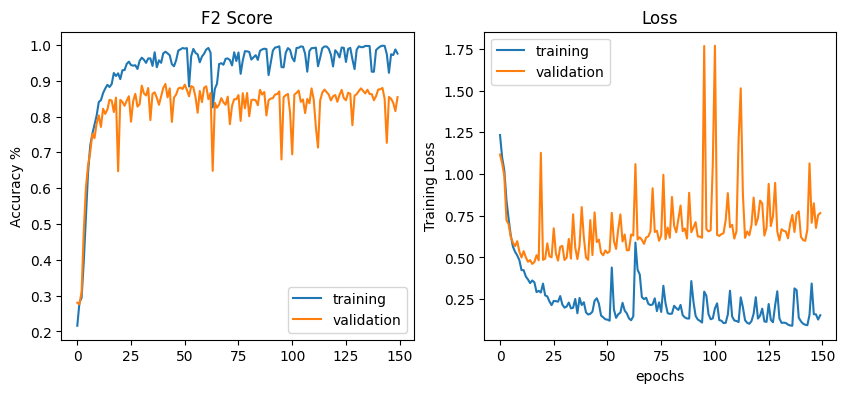

 1/22 [>.............................] - ETA: 0s

22/22 [==============================] - 0s 3ms/step


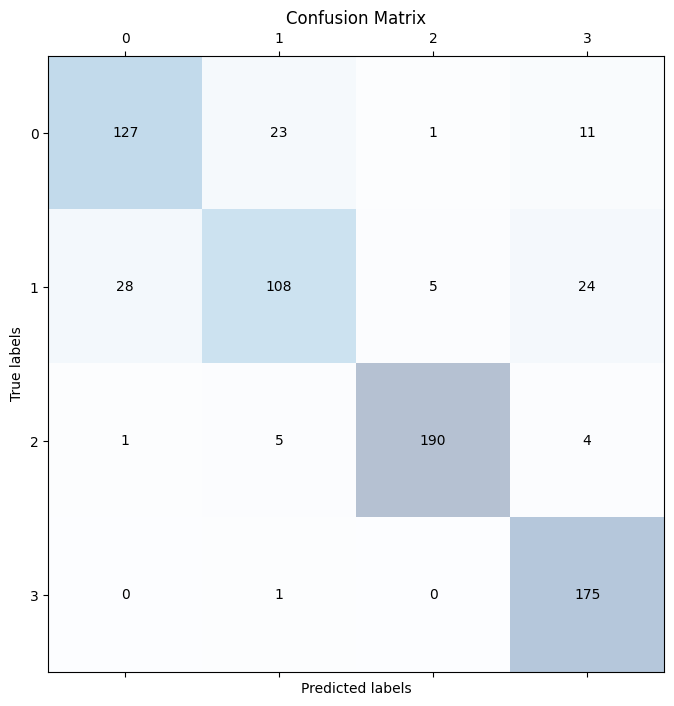

Validation Scores:
	F2 Score: [0.28009337186813354, 0.2758274972438812, 0.31012868881225586, 0.4770932197570801, 0.5999397039413452, 0.6638755798339844, 0.6994742751121521, 0.7521739602088928, 0.7395591139793396, 0.7806638479232788, 0.8031609058380127, 0.7710011601448059, 0.8216029405593872, 0.8072393536567688, 0.8192737102508545, 0.84670490026474, 0.8445078134536743, 0.812624990940094, 0.8528236746788025, 0.6471428275108337, 0.8466362953186035, 0.8404679894447327, 0.8299943208694458, 0.844266951084137, 0.8566134572029114, 0.7855717539787292, 0.8430812954902649, 0.863493800163269, 0.8276352882385254, 0.8345221877098083, 0.8862019777297974, 0.8646724224090576, 0.8587297201156616, 0.8795900940895081, 0.7900741696357727, 0.863493800163269, 0.8675214052200317, 0.8523375391960144, 0.832621693611145, 0.855637788772583, 0.8795900940895081, 0.8909763693809509, 0.8535194993019104, 0.8786670565605164, 0.7849002480506897, 0.8530332446098328, 0.8615779280662537, 0.878416895866394, 0.88076275587081

In [51]:
# Plot Training F2 score
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(mlp_history.history['f2_score'], label = 'training')

# Plot Val F2 score
plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(mlp_history.history['val_f2_score'], label = 'validation')
plt.title('F2 Score')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(mlp_history.history['loss'], label = 'training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

# Plot Validation Loss
plt.plot(mlp_history.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

# After training, predict classes on the test set
y_pred = mlp.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print the scores
print(f"Validation Scores:\n\tF2 Score: {mlp_history.history['val_f2_score']}\n\tRecall: {mlp_history.history['val_recall_16']}")
print(f"\tPrecision: {mlp_history.history['val_precision_16']}\n\tAccuracy: {mlp_history.history['val_accuracy']}")

In [52]:
# LARSON CODE

from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels = 'auto'):
    plt.figure(figsize = (15, 5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis = 1)
        acc_cnn = mt.accuracy_score(y_test, yhat_cnn)
        plt.subplot(1, 2, 1)
        cm = mt.confusion_matrix(y_test, yhat_cnn)
        cm = cm / np.sum(cm, axis = 1)[:, np.newaxis]
        sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = labels, yticklabels = labels)
        plt.title(f'CNN: {acc_cnn:.4f}')
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis = 1)
        acc_mlp = mt.accuracy_score(y_test, yhat_mlp)
        plt.subplot(1, 2, 2)
        cm = mt.confusion_matrix(y_test, yhat_mlp)
        cm = cm / np.sum(cm, axis = 1)[:, np.newaxis]
        sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = labels, yticklabels = labels)
        plt.title(f'MLP: {acc_mlp:.4f}')

22/22 [==============================] - 0s 3ms/step


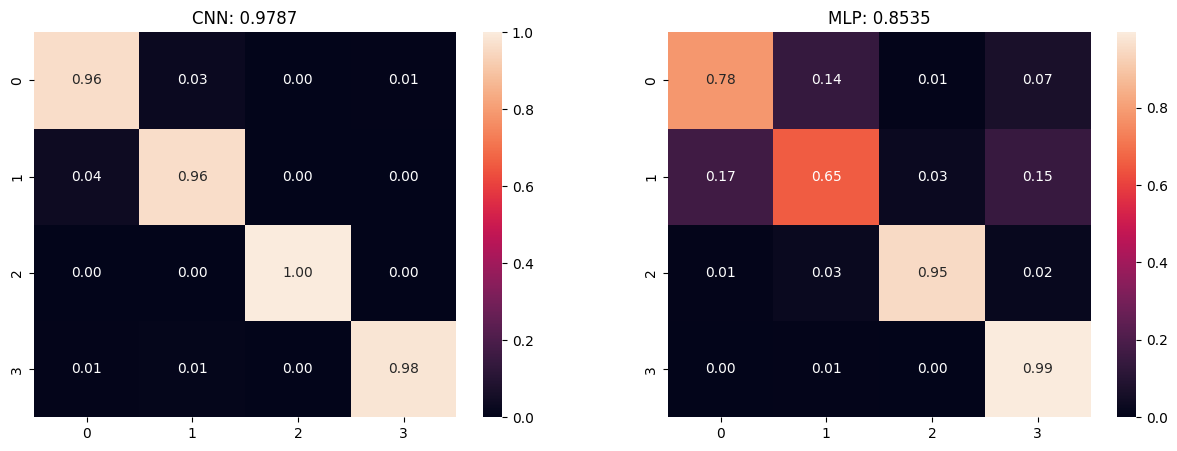

In [53]:
# Compare Best Convolution Against MLP
compare_mlp_cnn(Conv2B, mlp, X_test, y_test)

22/22 [==============================] - 0s 3ms/step


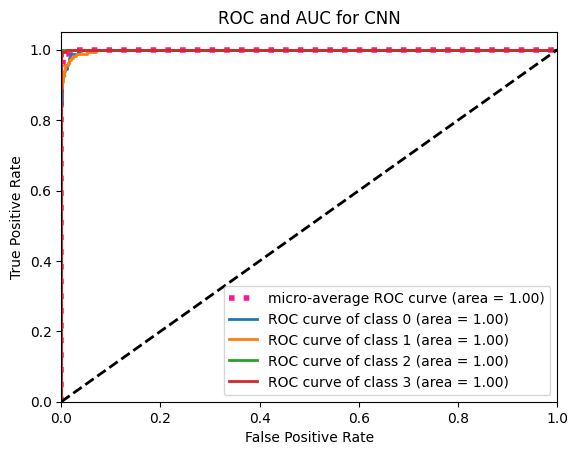

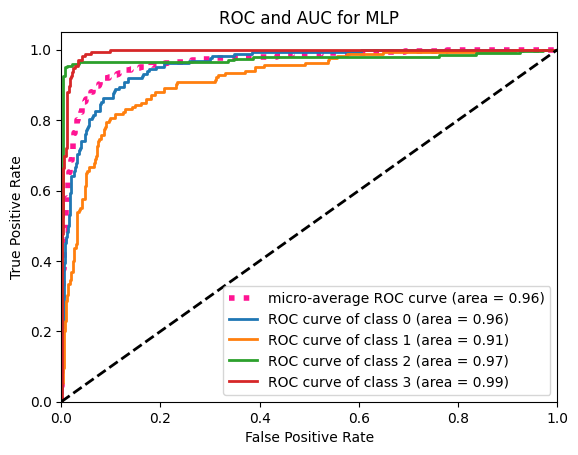

In [54]:
# Predict the probabilities for each class (CNN and MLP)
y_pred_cnn = Conv2B.predict(X_test)
y_pred_mlp = mlp.predict(X_test)

# Plot ROC and calculate AUC (CNN)
plot_roc_curve(y_test, y_pred_cnn, NUM_CLASSES, 'CNN')

# Plot ROC and calculate AUC (MLP)
plot_roc_curve(y_test, y_pred_mlp, NUM_CLASSES, 'MLP')

- F2 Score: 0.8542
- Recall: 0.8535
- Precision: 0.8571
- Accuracy: 0.8535

The provided confusion matrix and performance metrics for the Multi-Layer Perceptron (MLP) from Scikit-learn show a model that performs well but does not reach the high levels of accuracy, precision, recall, and F2 score seen in our best CNN.

CNNs are inherently designed to recognize spatial hierarchies in data. By using convolutional layers, CNNs automatically and adaptively learn spatial hierarchies of features from input images. This is especially beneficial for image data like MRIs where tumor patterns are spatially localized and can vary in size and shape. The MLP lacks this level of sophisticated feature extraction since it treats input data as flat vectors, which can lead to a loss of spatial context that is crucial for accurate image classification.

CNNs are also more robust to variations in the image due to their architecture. They can handle variations in the position and orientation of objects in an image, which is essential for medical images where tumors can appear in different locations and scales.

The CNN's F2 score of 0.9872 is significantly higher than the MLP's 0.8542. This indicates that the CNN is more effective at minimizing false negatives, an important consideration in medical diagnostics where missing a positive case can have serious consequences. The CNN also has a higher recall, meaning it correctly identifies more true positives than the MLP, which is crucial for tumor detection tasks. The CNN's accuracy is higher, showing that overall, it classifies the images correctly more often than the MLP.

The superiority of the CNN's architecture for image-related tasks is clear. Its ability to process images in a way that retains the spatial and structural information makes it better suited for medical imaging challenges. The CNN's robustness, efficiency in handling high-dimensional data, and superior feature extraction capabilities directly translate to its higher performance metrics compared to the MLP.

## **4: Exceptional Credit - Transfer Learning with VGG-19**

For exceptional credit, we implemented a deep learning model to classify brain tumor MRI scans using transfer learning with the VGG-19 network in PyTorch. 

First, we import the necessary libraries and modules for the task. 

In [10]:
# Import Statements
from sklearn.metrics import (
    fbeta_score, 
    precision_score, 
    recall_score, 
    confusion_matrix,
    roc_auc_score, 
    roc_curve,
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
import torchvision.models as models
from torch.utils.data import (
    DataLoader, 
    TensorDataset, 
    Dataset,
)

First, we'll load the VGG-19 model, which is pre-trained on ImageNet, with batch normalization. The pre-training helps in leveraging learned features from a vast and diverse dataset. Leveraging a pre-trained model accelerates the learning proces and often leads to better performance when the available dataset is not extremely large. 

Then, we modify the model for the current task. We replace the last layer of the classifier with a new linear layer to output 4 classes that correspond to our tumor categories. Modifying the model to suit the specific requirements of our tasks demonstrates an effective approach to applying deep learning in medical imaging. 

Then, we transfer the model to a GPU is available for efficient computation. 

In [11]:
# Modify VGG19 Model
vgg19 = models.vgg19_bn(pretrained = True)
vgg19.classifier[6] = nn.Linear(vgg19.classifier[6].in_features, 4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
vgg19.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

After modifying the model, we prepare the datasets for PyTorch. We convert the MRI images (stored as numpy arrays) to PyTorch tensors. Since VGG-19 expects 3-channel RGB input, the grayscale MRI images are repeated across three channels. 

Then we create datasets and data loaders. The image tensors and their labels are wrapped in 'TensorDataset', and 'DataLoader' is used to efficiently iterate over the dataset in batches during training and testing.

In [12]:
# 2. Prepare datasets for PyTorch
# Convert the loaded MRI images (numpy arrays) to PyTorch tensors
# Convert grayscale images to RGB format by repeating the single channel three times
train_tensors: Tensor = (
    torch.tensor(train_paths)
    .float()
    .view(-1, 1, IMG_SIZE, IMG_SIZE)
    .repeat(1, 3, 1, 1)  # GRAYSCALE IMAGE TO RGB FORMAT FOR torch.models 
)
test_tensors: Tensor = (
    torch.tensor(test_paths)
    .float()
    .view(-1, 1, IMG_SIZE, IMG_SIZE)
    .repeat(1, 3, 1, 1)  # GRAYSCALE IMAGE TO RGB FORMAT FOR torch.models
)

# Convert the image labels into tensor format for PyTorch
train_labels: Tensor = torch.tensor(train_labels).long()
test_labels: Tensor = torch.tensor(test_labels).long()

# Create PyTorch datasets using the image tensors and their corresponding labels
train_dataset: Dataset = TensorDataset(train_tensors, train_labels)
test_dataset: Dataset = TensorDataset(test_tensors, test_labels)

# Define data loaders to efficiently load image batches during training/testing
BATCH_SIZE: int = 64
train_loader: DataLoader = (
    DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,  # Shuffling helps in better model generalization
    )
)
test_loader: DataLoader = (
    DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False,  # No need to shuffle test data
    )
)

Finally, we get to train the model. We use cross-entropy loss because it is suitable for multiclass classification tasks. We also chose to use Adam optimizer for optimization.

The model is trained over a specified number of epochs, where in each epoch, the model's parameters are updated to minimize the loss. 

The F2 score, which emphasizes recall, is computed for each epoch to reflect the model's performance in correctly identifying tumor classes. We then store the training loss and F2 scores for each epoch to monitor and analyze the model's learning process. 

In [13]:
# Train The Model
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg19.parameters(), lr=0.001)
train_losses, f2_scores = [], []

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    vgg19.train()  # Set the model to training mode
    train_loss = 0.0  # Initialize training loss
    all_labels, all_predictions = [], []

    # For each batch of images and labels
    for images, labels in train_loader:
        images = images.to(device)  # Send data to the device (GPU/CPU)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Zero out any previous gradients
        outputs = vgg19(images)  # Forward pass: Get model predictions
        _, predicted = torch.max(outputs.data, 1)  # Get the class with highest predicted probability
        loss = criterion(outputs, labels)  # Compute the loss for this batch
        loss.backward()  # Backward pass: compute the gradient of the loss w.r.t. model parameters
        optimizer.step()  # Update the model's weights
        
        train_loss += loss.item()  # Accumulate the training loss

        # Storing labels & predictions for computing F2 score and confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    # Compute the epoch's F2 score
    epoch_f2_score = fbeta_score(all_labels, all_predictions, average='macro', beta=2)
    epoch_loss = train_loss / len(train_loader)
    train_losses.append(epoch_loss)
    f2_scores.append(epoch_f2_score)

    # Print training loss and F2 score for this epoch        
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Training loss: {epoch_loss}, F2 Score: {epoch_f2_score}")

Epoch 1/10 - Training loss: 0.7113999189602004, F2 Score: 0.765055633742096
Epoch 2/10 - Training loss: 0.4275264526406924, F2 Score: 0.8488475010758443
Epoch 3/10 - Training loss: 0.3381458747718069, F2 Score: 0.879236050768266
Epoch 4/10 - Training loss: 0.30659198777543173, F2 Score: 0.8891253965114588
Epoch 5/10 - Training loss: 0.24672695696353913, F2 Score: 0.9108673835264186
Epoch 6/10 - Training loss: 0.28771249391138554, F2 Score: 0.9021895381454483
Epoch 7/10 - Training loss: 0.16328175332811143, F2 Score: 0.943971367981084
Epoch 8/10 - Training loss: 0.14742334050436814, F2 Score: 0.9487558418826917
Epoch 9/10 - Training loss: 0.1337707839699255, F2 Score: 0.9527968389489881
Epoch 10/10 - Training loss: 0.1328246280964878, F2 Score: 0.959669909710619


The output provides insight into the training process and performance of the adapted VGG-19 model over 10 epochs. 

We see a decreasing training loss, starting from 0.7114 and going down to 0.1328 in the last epoch, indicating that the model is effectively learning from the training data. The decreasing loss means that the model's predictions are getting closer to the actual labels, improving its accuracy. 

We also see an increasing F2 score, starting at 0.7650 and goes up to 0.9597, suggesting that the model is becoming better at correctly identifying the different classes, particularly focusing on reducing false negatives. Reducing false negatives is crucial in medical diagnosis tasks. A high F2 score is desirable in this case because it indicates that the model is reliable in detecting tumors. 

The consistent improvement over epochs in both training loss and F2 score suggests that the model is learning effectively and generalizes well to the training data, which is a positive sign that the model will likely perform well on unseen data, assuming that the test data has a similar distribution to the training data. 

Additionally, the F2 score reaching close to 0.96 in the final epoch is a strong indicator that the model is robust, especially in terms of its ability to minimize false negatives. In this medical context, the model's robustness is key to ensuring that the model can be trusted for medical diagnosis purposes, where missing a tumor can have serious implications. 

Precision: 0.8496126693519013, Recall: 0.7673202614379084, F2 Score: 0.7664428535216011, AUC: 0.9561580262712889
Confusion Matrix:
[[246  10  44   0]
 [ 31 215  59   1]
 [  0   0 405   0]
 [ 19  10 107 164]]


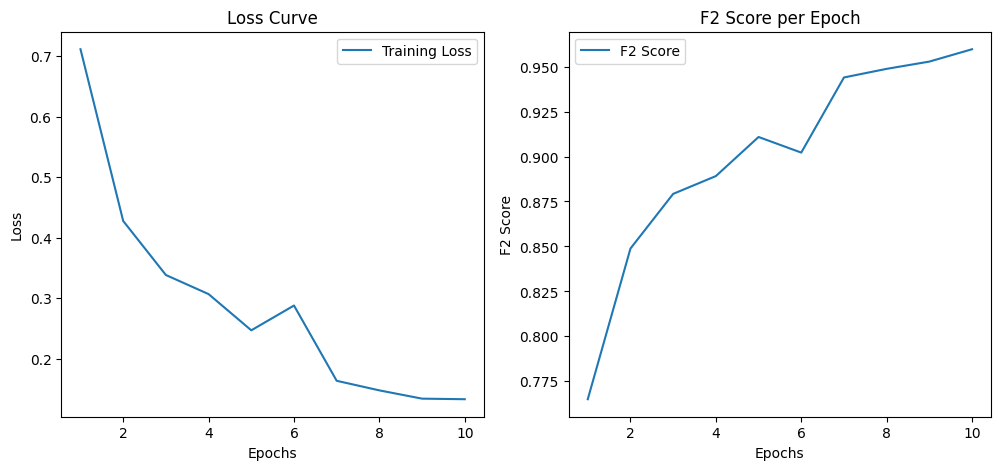

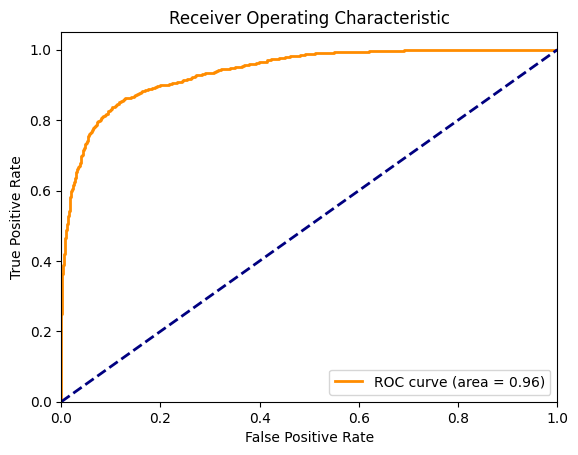

In [16]:
# Set Model To Eval Mode
vgg19.eval()

# Initialize Lists To Store Labels, Predictions
all_labels = []
all_prob_predictions = []

# We Won't Update Model
with torch.no_grad():
    for images, labels in test_loader:

        # Move Images, Labels To Device
        images = images.to(device)
        labels = labels.to(device)

        # Get Model Outputs
        outputs = vgg19(images)

        # Get Probabilities Using Softmax
        probabilities = torch.softmax(outputs, dim = 1)

        # Store True Labels, Probabilities
        all_labels.extend(labels.cpu().numpy())
        all_prob_predictions.extend(probabilities.cpu().numpy())

# Convert Lists -> NumPy Arrays
all_labels_array = np.array(all_labels)
all_prob_predictions_array = np.array(all_prob_predictions)

# Binarize Labels For Multi-Class ROC AUC
all_labels_binarized = label_binarize(all_labels_array, classes = range(4))

# Calculate AUC
auc_score = roc_auc_score(all_labels_binarized, all_prob_predictions_array, multi_class = 'ovr')

# Additional Metrics
all_predictions = np.argmax(all_prob_predictions_array, axis = 1)
precision = precision_score(all_labels_array, all_predictions, average = 'macro')
recall = recall_score(all_labels_array, all_predictions, average = 'macro')
f2_score = fbeta_score(all_labels_array, all_predictions, average = 'macro', beta = 2)
conf_matrix = confusion_matrix(all_labels_array, all_predictions)

# Print Metrics
print(f"Precision: {precision}, Recall: {recall}, F2 Score: {f2_score}, AUC: {auc_score}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plotting Loss Curve, F2 Score For Each Epoch
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label = 'Training Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), f2_scores, label = 'F2 Score')
plt.title('F2 Score per Epoch')
plt.xlabel('Epochs')
plt.ylabel('F2 Score')
plt.legend()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels_binarized.ravel(), all_prob_predictions_array.ravel())
plt.figure()
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")
plt.show()

The output provides comprehensive performance metrics for the VGG-19 model on the test dataset for the brain tumor MRI scan classification task. 

Precision (0.8496): High precision indicates that, among the instances the model predicted as positive, a large proportion was correct, meaning the model has a low rate of false positives.

Recall (0.7673): This metric is slightly lower than precision, suggesting that the model missed a notable number of positive cases (false negatives).

F2 Score (0.7664): This score, which gives more weight to recall, is similar to the recall value, indicating that the model's ability to correctly identify positive cases (especially important in medical diagnostics) is reasonable but could be improved.

AUC (0.9562): A high AUC value suggests that the model is quite capable of distinguishing between the different classes (e.g., types of tumors and no tumor).

The confusion matrix presents the model's predictions against the actual labels.

Most Confident in 'No Tumor' Class: 
The model has high accuracy for 'No Tumor' class (405 out of 405 correct).

Struggles with Meningioma and Pituitary: 
There are significant misclassifications between Meningioma (1) and Pituitary (3), indicating potential difficulty in distinguishing these classes.

Moderate Performance on Glioma: 
Glioma (0) is mostly classified correctly but has some confusion with Meningioma (1) and 'No Tumor' (2).

The plots for training loss and F2 Score over epochs provide a visual representation of the model's learning process:

The decreasing loss curve indicates that the model is increasingly fitting the training data well.
The increasing F2 score curve shows the model’s growing ability to correctly identify positive cases, with more emphasis on reducing false negatives.

The ROC curve and the AUC value (0.9562) provide a graphical representation of the model’s diagnostic ability. A curve closer to the top-left corner indicates a better performance, so the outputted plot is a relatively good curve. 

Overall, the model demonstrates strong capabilities in classifying brain tumor MRI scans, particularly doing well in identifying the 'No Tumor' class. However, there is room for improvement when differentiating between tumor types, particularly between Meningioma and Pituitary tumors.

The high AUC score indicates good model discrimination ability between the classes. The moderate recall and F2 score suggest a need for more tuning to improve the model's sensitivity to reduce the number of missed tumor cases. 